# Data

## AWID3 Dataset

AWID3 dataset consists of 13 captures of traffic in a wireless network. Of these 7 that focus on attacks on IEEE 802.11 MAC layer. The attacks chosen are: 

* Deauth
* Disass
* (Re)Assoc
* RogueAP
* Krack
* Kr00k
* Evil Twin

## Data preprocessing

For training of the model 

Features selection was based on [Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems](https://ieeexplore.ieee.org/document/9797689) by the authors of the AWID3 dataset:

### Features chosen by Chatzoglou et. al. and their preprocessing

| Feature                    | Preprocessing    |
|----------------------------|------------------|
| frame.len                  | Min-Max Scaling  |
| radiotap.len               | Min-Max Scaling  |
| radiotap.dbm_antsignal     | Min-Max Scaling  |
| wlan.duration              | Min-Max Scaling  |
| radiotap.present.tsft      | One Hot Encoding |
| radiotap.channel.freq      | One Hot Encoding |
| radiotap.channel.type.cck  | One Hot Encoding |
| radiotap.channel.type.ofdm | One Hot Encoding |
| wlan.fc.type               | One Hot Encoding |
| wlan.fc.subtype            | One Hot Encoding |
| wlan.fc.ds                 | One Hot Encoding |
| wlan.fc.frag               | One Hot Encoding |
| wlan.fc.retry              | One Hot Encoding |
| wlan.fc.pwrmgt             | One Hot Encoding |
| wlan.fc.moredata           | One Hot Encoding |
| wlan.fc.protected          | One Hot Encoding |

The chosen features were prepocessed with following differences:
* frame.delta_time was was was added, as it is crucial for analyzing temproal patterns.
* features expressed by 0/1 values, such as IEEE 802.11 Frame Control flags were left unchanged (e.g. frag, retry), not One Hot Encoded as in above mentioned article.
* the authors  One Hot Encoding of channel frequencies, however such approach is only feasable, when there rather few categories (3 frequencies were used in the above mentioned files), so a more genral method of preprocessing frequncy is proposed:
    * create two binary features `2ghz_spectrum` and `5ghz_spectrum` to indicate in which band a frame was sent
    * apply Min-Max Scaling to frequency, using the highest and the lowest channel frequency in given band as Min and Max values, as seen below

In [1]:
def preporcess_frequency(radiotap_channel_freq):
    lower_2ghz, higher_2ghz = 2412, 2472
    lower_5ghz, higher_5gzh = 5160, 5885
    
    if (lower_2ghz <= radiotap_channel_freq <= higher_2ghz):
        _2ghz_spectrum = 1
        _5gzh_spectrum = 0
        freq = (radiotap_channel_freq - lower_2ghz) / (higher_2ghz - lower_2ghz)
    elif (lower_5ghz <= radiotap_channel_freq <= higher_5ghz):
        _2ghz_spectrum = 0
        _5gzh_spectrum = 1
        freq = (radiotap_channel_freq - lower_5ghz) / (higher_5ghz - lower_5ghz)
    else:
        _2ghz_spectrum = 0
        _5gzh_spectrum = 0
        freq = -1
        
    return _2ghz_spectrum, _5gzh_spectrum, freq
     

### Features and used preprocessing

| Feature                   | Type        | Preprocessing       | Values                    | Description                                                                                                       |
|---------------------------|-------------|---------------------|---------------------------|-------------------------------------------------------------------------------------------------------------------|
| frame.len                 | numeric     | Min-Max Scaling     | from 70 to 3220           | Length of frame, in bytes                                                                                         |
| frame.time_delta          | numeric     | Min-Max Scaling     | from 0 to 0.001817        | Time interval since previous frame, in seconds                                                                    |
| radiotap.len              | numeric     | Min-Max Scaling     | from 48 to 64             | Length of Radiotap header, in bytes                                                                               |
| radiotap.dbm_antsignal    | numeric     | Min-Max Scaling     | form -255 to -78          | Strength of recieved signal, in dBm. In AWID3 CSV files the value was summarized for antennas, hence very low values |
| wlan.duration             | numeric     | Min-Max Scaling     | from 0 to 726             | Duration/Id field in IEEE 802.11 header                                                                           |
| wlan.fc.type              | categorical | One Hot Encoding    | 0, 1, 2                   | IEEE 802.11 frame type: Management, Control or Data                                                               |
| wlan.fc.subtype           | categorical | One Hot Encoding    | 0, 1, ... 14, 15          | IEEE 802.11 frame subtype                                                                                         |
| wlan.fc.ds                | categorical | One Hot Encoding    | 0, 1, 2, 3                | Indicates whete a frame was sent to (tods) or from (fromds) a Distribution System (ds), neither or both           |
| radiotap.present.tsft     | binary      | convert to 0,1      | '0-0-0', '1-0-0'          | Presence of TSFT (Time Synchroniztion Function) in Radiotap header                                                |
| radiotap.channel.type.cck | binary      | None                | 0, 1                      | Whether frame was sent using CCK (Complemantary Code Keying), used in IEEE 802.11b                                |
| radiotap.channel.type.ofdm | binary     | None                | 0, 1                      | Whether frame was sent using OFDM (Orthognal Frequency Division Multiplexing) modulation                          |
| wlan.fc.frag              | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame was fragmented                                                         |
| wlan.fc.retry             | binary      | None                | 0, 1                      | Frame Control flag, indicates if the frame is retransmission of a previous frame                                  |
| wlan.fc.pwrmgt            | binary      | None                | 0, 1                      | Frame Control flag, used when station enters power management state                                               |
| wlan.fc.moredata          | binary      | None                | 0, 1                      | Frame Control flag, indicates that AP has buffered for the station                                                |
| wlan.fc.protected         | binary      | None                | 0, 1                      | Frame Control flag, indicates that frame has been encrypted                                                       |
| 2ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 2.4GHz band                                                               |
| 5ghz_spectrum             | binary      | None                | 0, 1                      | The channel the frame was sent in is in 5GHz band                                                                 |
| freq                      | numeric     | As described above  | from 0 to 1               | Frequency scaled for the band station works in                                                                    |
| Label                     | Categorical | Convert to 0, 1, 2  | 'Normal' and attacks      | Label of given to the frame                                                                                      | 

Minimal and maximal values for ranges were estimated accros all AWID3 files, IQR was used to exckude otliers, that were then clipped into range 0, 1.

The traffic was divided into 3 classes:

Classes:

| Class | name           | Attacks                                                               |
|-------|----------------|-----------------------------------------------------------------------|
| 0     | normal         |                                                                       |
| 1     | flooding       | Deauth, Disass, (Re)Assoc, Kr00k                                      |
| 2     | impersonation  | RogueAP, Krack, Evil Twin                                             |

Both binary, and multiclass classificators were trained and evaluated on the dataset.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np

tfrecords_dir='dataset/AWID3_tfrecords'
tfrecords_balanced_dir='dataset/AWID3_tfrecords_balanced'

sequence_length = 128
sequence_shift = 120
n_features = 39

from collections import defaultdict

In [3]:
import data_utils

files = os.listdir(tfrecords_dir)

train_ratio = 0.8
val_ratio = 0.75
train_files, test_files = data_utils.train_test_split(files, train_ratio=train_ratio)
train_files, val_files = data_utils.train_test_split(train_files, train_ratio=val_ratio)

print("Training set:")
for t in train_files:
    print(t.split('.')[0], end=', ')

print("\nValidation set:")
for t in val_files:
    print(t.split('.')[0], end=', ')

print("\nTest set:")
for t in test_files:
    print(t.split('.')[0], end=', ')
    
train_seq_files = [os.path.join(tfrecords_dir, f) for f in train_files]
val_seq_files = [os.path.join(tfrecords_dir, f) for f in val_files]
test_seq_files = [os.path.join(tfrecords_dir, f) for f in test_files]
train_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in train_files]
val_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in val_files]
test_bal_files = [os.path.join(tfrecords_balanced_dir, f) for f in test_files]



Training set:
Kr00k_40, RogueAP_37, Kr00k_36, Evil_Twin_36, Kr00k_55, Evil_Twin_29, Kr00k_51, (Re)Assoc_22, Evil_Twin_37, (Re)Assoc_25, Evil_Twin_44, Evil_Twin_33, Evil_Twin_58, RogueAP_29, Kr00k_33, Disas_38, Disas_39, Evil_Twin_75, Kr00k_34, (Re)Assoc_34, RogueAP_35, (Re)Assoc_31, RogueAP_24, Deauth_32, RogueAP_31, (Re)Assoc_23, (Re)Assoc_32, Deauth_27, (Re)Assoc_35, Kr00k_32, Evil_Twin_39, Kr00k_57, Deauth_25, RogueAP_28, Deauth_29, Disas_36, Evil_Twin_59, Kr00k_56, Deauth_22, Evil_Twin_69, RogueAP_25, Evil_Twin_63, Kr00k_42, Evil_Twin_74, Evil_Twin_30, Evil_Twin_65, Disas_35, (Re)Assoc_28, Disas_40, Disas_37, Krack_25, Evil_Twin_61, Evil_Twin_68, Kr00k_46, (Re)Assoc_24, Kr00k_39, Evil_Twin_54, Deauth_21, Evil_Twin_70, Disas_29, Evil_Twin_46, Evil_Twin_51, Evil_Twin_52, RogueAP_27, Deauth_23, Evil_Twin_60, (Re)Assoc_26, Kr00k_53, Krack_26, Evil_Twin_72, Kr00k_48, RogueAP_26, Evil_Twin_40, Disas_28, Deauth_31, Evil_Twin_47, RogueAP_39, Evil_Twin_66, Evil_Twin_71, Evil_Twin_42, Kr00k_

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import seaborn as sns

# functions for plotting and confusion matrix

def score_and_confusion_matrix(y_pred, y_true, title : str, binary = True, average='binary'):
    class_names = [
        'Normal', 'Attack'
    ] if binary else [
        'Normal', 'Flooding', 'Impersonation'
    ]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f'Accuracy: {100*accuracy:2.3f}%')
    print(f'Precision: {100*precision:2.3f}%')
    print(f'Recall: {100*recall:2.3f}%')
    print(f'F1 : {f1:.5f}')
    print(f'Kappa: {kappa:.5f}')
    
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    
    return accuracy, precision, recall, f1, kappa
    
def plot_model_history(history, title):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(title)
    
    if 'accuracy' in history:
        axes[0, 0].plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            axes[0, 0].plot(history['val_accuracy'], label='Val Accuracy')
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].set_xlabel('Epochs')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
    
    # Plot Precision
    if 'precision' in history:
        axes[0, 1].plot(history['precision'], label='Train Precision')
        if 'val_precision' in history:
            axes[0, 1].plot(history['val_precision'], label='Val Precision')
        axes[0, 1].set_title('Precision')
        axes[0, 1].set_xlabel('Epochs')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].legend()
    
    if 'recall' in history:
        axes[1, 0].plot(history['recall'], label='Train Recall')
        if 'val_recall' in history:
            axes[1, 0].plot(history['val_recall'], label='Val Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].legend()
    
    if 'loss' in history:
        axes[1, 1].plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1, 1].plot(history['val_loss'], label='Val Loss')
        axes[1, 1].set_title('Loss')
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()    
    plt.tight_layout()
    plt.show()
        

In [5]:
import binary_cnn_lstm
import data_utils

bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()

if not bin_cnn_lstm_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    model = bin_cnn_lstm_model
    model.fit(
            data_utils.create_binary_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_bal_files),
            epochs = 10,
        )
    history = model.fit(
            data_utils.create_binary_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_seq_files),
            epochs = 10,
            callbacks = binary_cnn_lstm.checkpoint_callback,
        )
    history = history.history
    
    
    plot_model_history(history, "Binary CNN-LSTM")
    print(history)
    #loading best checkpoint
    bin_cnn_lstm_model = binary_cnn_lstm.binary_CNN_LSTM_model()
    
bin_cnn_lstm_model.name = 'bin_CNN_LSTM'    
bin_cnn_lstm_model.summary()


I0000 00:00:1736105302.107833  496778 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model loaded from saved_models/binary_cnn_lstm.keras


Model: "bin_CNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,693 (119.90 KB)

 Trainable params: 10,209 (39.88 KB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 20,420 (79.77 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Accuracy: 99.792%
Precision: 98.872%
Recall: 99.447%
F1 : 0.99159
Kappa: 0.99040


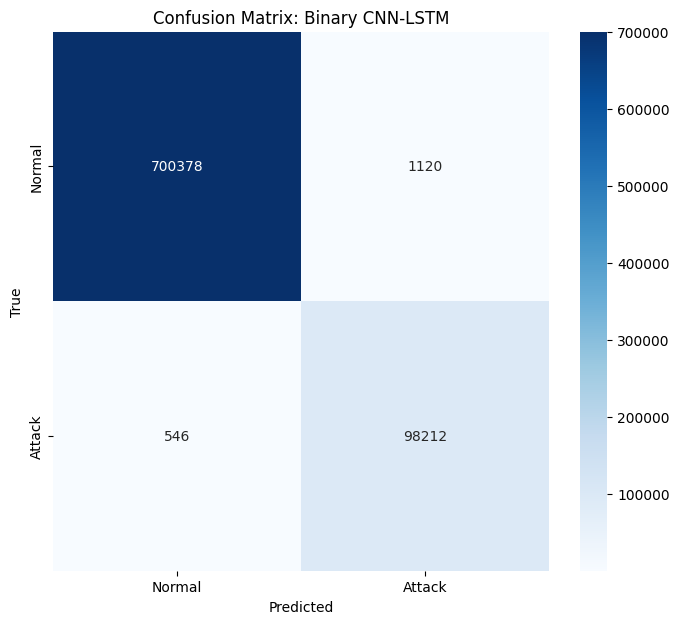

In [6]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_lstm_model.predict(features).flatten()
y_pred = (y_pred > 0.5).astype(int)
y_true = labels.numpy().flatten()
    
bin_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-LSTM")


In [7]:
import binary_td_cnn
import data_utils

bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()

if not bin_td_cnn_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    model = bin_td_cnn_model
    model.fit(
            data_utils.create_binary_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_bal_files),
            epochs = 10,
        )
    history = model.fit(
            data_utils.create_binary_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_seq_files),
            epochs = 10,
            callbacks = binary_td_cnn.checkpoint_callback,
        )
    history = history.history
    
    plot_model_history(history, "Binary Time Domain CNN")
    #loading best checkpoint
    bin_td_cnn_model = binary_td_cnn.binary_time_domain_CNN_model()
    
bin_td_cnn_model.name = 'bin_TD_CNN'    
bin_td_cnn_model.summary()

Model loaded from saved_models/binary_td_cnn.keras


Model: "bin_TD_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 16)       │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 16)       │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,341 (48.21 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 8,164 (31.89 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 99.611%
Precision: 99.595%
Recall: 97.245%
F1 : 0.98406
Kappa: 0.98184


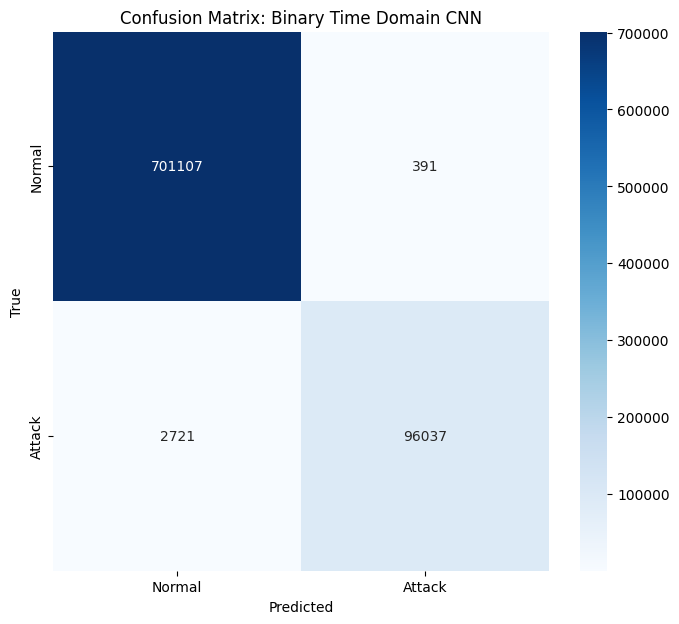

In [8]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_td_cnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary Time Domain CNN")


In [9]:
import binary_cnn_gru
import data_utils

bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model() 

if not bin_cnn_gru_model.built:
    dataset_lambda = lambda x: data_utils.create_binary_sequential_dataset(x)
    model = bin_cnn_gru_model
    model.fit(
            data_utils.create_binary_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_bal_files),
            epochs = 10,
        )
    history = model.fit(
            data_utils.create_binary_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_binary_sequential_dataset(val_seq_files),
            epochs = 10,
            callbacks = binary_cnn_gru.checkpoint_callback,
        )
    history = history.history
    
    plot_model_history(history, "Binary CNN")
    #loading best checkpoint
    bin_cnn_gru_model = binary_cnn_gru.binary_CNN_GRU_model()
    
    
bin_cnn_gru_model.summary()
bin_cnn_gru_model.name = 'binary_CNN_GRU'

Model loaded from saved_models/binary_cnn_gru.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 24)       │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 16)       │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,981 (58.52 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,988 (39.02 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Accuracy: 99.552%
Precision: 99.160%
Recall: 97.191%
F1 : 0.98166
Kappa: 0.97910


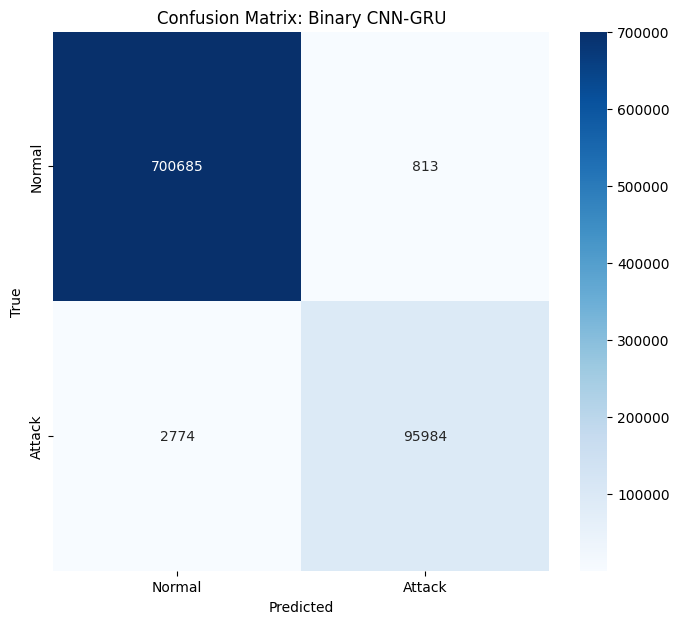

In [10]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_cnn_gru_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
bin_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Binary CNN-GRU")


Model loaded from saved_models/binary_cnn1d.keras


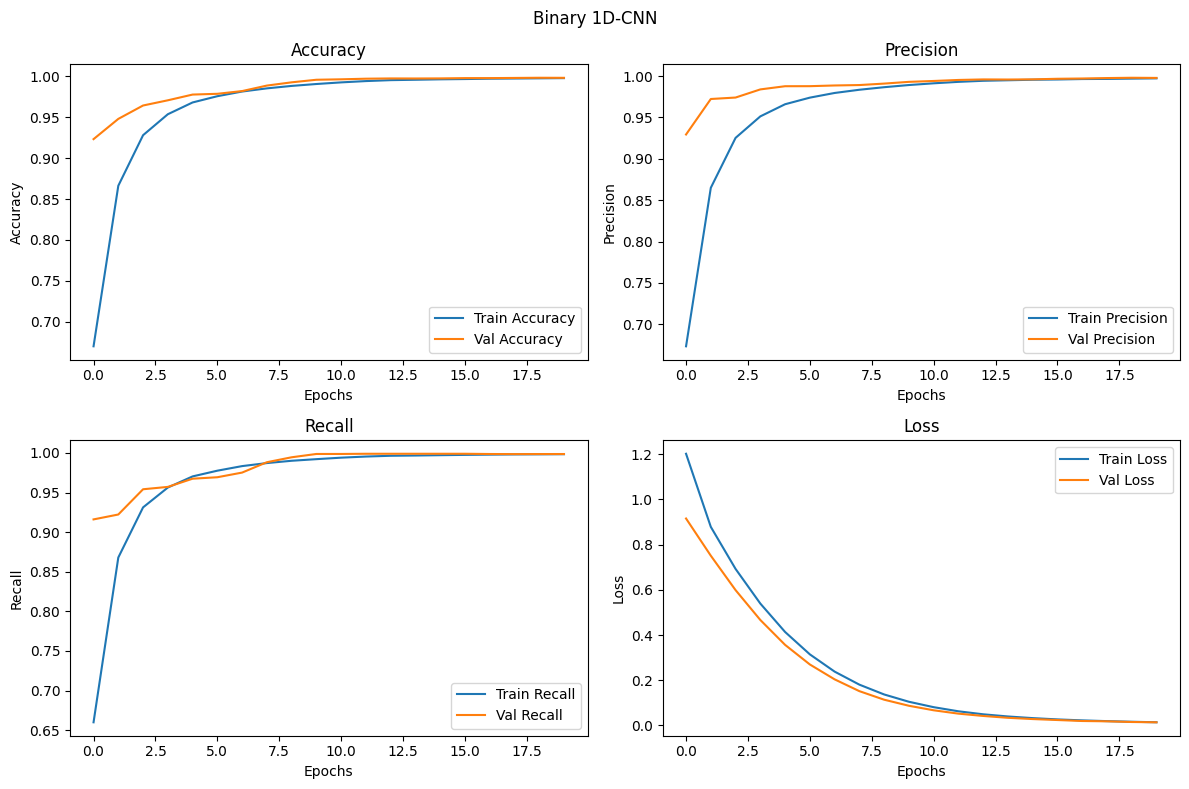

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 39, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 39, 24)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 24)         │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 12)         │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 39, 12)         │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 468)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         3,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,681 (49.54 KB)

 Trainable params: 4,197 (16.39 KB)

 Non-trainable params: 88 (352.00 B)

 Optimizer params: 8,396 (32.80 KB)

In [11]:
import binary_cnn1d
import data_utils

bin_cnn1d_model = binary_cnn1d.binary_CNN1D_model()

if not bin_cnn1d_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_cnn1d_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=20,
            callbacks = [binary_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Binary 1D-CNN')
else:
    history = {'accuracy': [0.6699162125587463, 0.8662096261978149, 0.9280219078063965, 0.9536494612693787, 0.9680593013763428, 0.9756919145584106, 0.9814156293869019, 0.985278844833374, 0.9882804751396179, 0.9906171560287476, 0.9926061630249023, 0.9941946864128113, 0.9953312277793884, 0.9958103895187378, 0.9963378310203552, 0.9966809153556824, 0.9971071481704712, 0.9973263144493103, 0.9975605607032776, 0.997796356678009], 'loss': [1.2016854286193848, 0.8783105611801147, 0.6923704743385315, 0.5391154289245605, 0.4135202467441559, 0.3144894242286682, 0.2382010966539383, 0.18054451048374176, 0.13712266087532043, 0.10484259575605392, 0.0808999314904213, 0.06268107146024704, 0.04938080906867981, 0.0397515706717968, 0.032470595091581345, 0.026790576055645943, 0.022472118958830833, 0.019156577065587044, 0.016390109434723854, 0.014111697673797607], 'precision': [0.673364520072937, 0.8649072647094727, 0.9252502918243408, 0.9512284398078918, 0.9658956527709961, 0.9738698601722717, 0.9795156717300415, 0.9834045767784119, 0.9864827394485474, 0.9891026020050049, 0.9911921620368958, 0.9929441213607788, 0.9942358136177063, 0.994870662689209, 0.9954943656921387, 0.9958054423332214, 0.9963417649269104, 0.9965171217918396, 0.9968605041503906, 0.9971680045127869], 'recall': [0.6599012017250061, 0.8679768443107605, 0.9312722682952881, 0.9563268423080444, 0.9703776836395264, 0.9776117205619812, 0.9833946824073792, 0.9872157573699951, 0.99012690782547, 0.9921643733978271, 0.9940447211265564, 0.9954624772071838, 0.9964389204978943, 0.9967593550682068, 0.9971886277198792, 0.9975634813308716, 0.997877836227417, 0.9981408715248108, 0.9982647895812988, 0.9984280467033386], 'val_accuracy': [0.9232061505317688, 0.9479648470878601, 0.9643326997756958, 0.9706944227218628, 0.9777042269706726, 0.9786415100097656, 0.9819719195365906, 0.988692581653595, 0.9926711320877075, 0.9958120584487915, 0.9963604807853699, 0.9970983862876892, 0.9974223971366882, 0.9973626136779785, 0.9974722862243652, 0.9978212714195251, 0.9978262782096863, 0.9980356693267822, 0.9982550144195557, 0.9981752634048462], 'val_loss': [0.9153164029121399, 0.7508149147033691, 0.5985990762710571, 0.4665278196334839, 0.35649099946022034, 0.2697801887989044, 0.2039521038532257, 0.15173424780368805, 0.1139429584145546, 0.08712058514356613, 0.06711874157190323, 0.05225455015897751, 0.04203810542821884, 0.033851850777864456, 0.02829846180975437, 0.024037804454565048, 0.019710296764969826, 0.01832299865782261, 0.015295598655939102, 0.013993613421916962], 'val_precision': [0.929334282875061, 0.9722332954406738, 0.9739876389503479, 0.9838188886642456, 0.9876746535301208, 0.98772794008255, 0.9885797500610352, 0.9890843629837036, 0.9908419847488403, 0.9929523468017578, 0.9940165877342224, 0.9952422976493835, 0.9958754181861877, 0.9957566261291504, 0.9959744215011597, 0.9966678619384766, 0.996994137763977, 0.9975299835205078, 0.9978978633880615, 0.9977090954780579], 'val_recall': [0.9160942435264587, 0.9222854971885681, 0.9541589021682739, 0.9571398496627808, 0.9674885272979736, 0.9693329334259033, 0.9752150774002075, 0.9882954359054565, 0.9945365786552429, 0.9987139105796814, 0.9987338185310364, 0.9989731311798096, 0.9989830851554871, 0.9989830851554871, 0.9989830851554871, 0.9989830851554871, 0.9986640214920044, 0.9985443949699402, 0.9986141920089722, 0.9986441135406494]}
    plot_model_history(history, 'Binary 1D-CNN')
    
bin_cnn1d_model.summary()


25008/25008 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step
Accuracy: 98.701%
Precision: 91.224%
Recall: 98.993%
F1 : 0.94950
Kappa: 0.94206


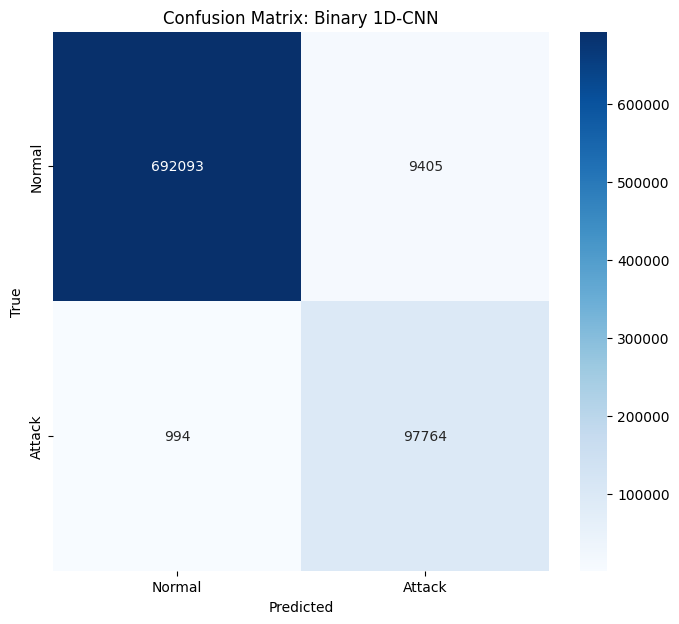

In [12]:
binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in binary_bal_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_cnn1d_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary 1D-CNN')


Model loaded from saved_models/binary_dnn.keras


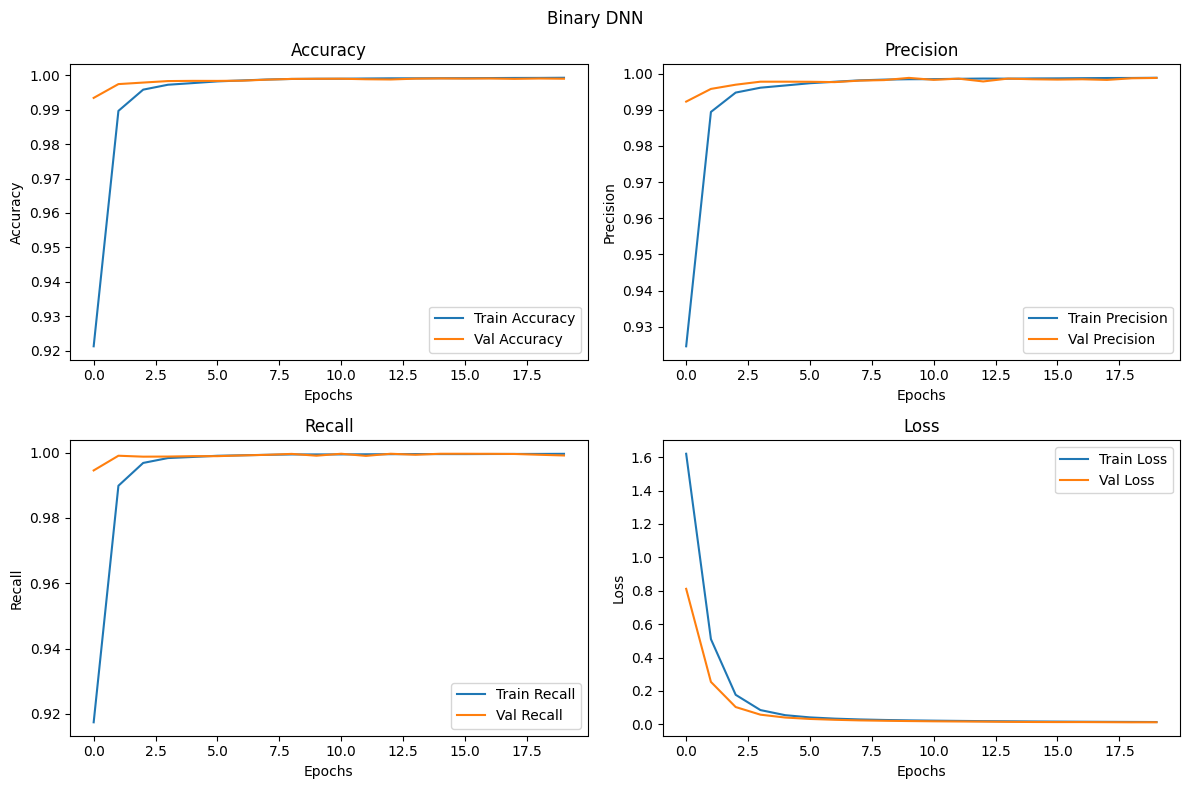

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,869 (50.27 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 8,452 (33.02 KB)

In [13]:
import binary_dnn
import data_utils

bin_dnn_model = binary_dnn.binary_DNN_model()

if not bin_dnn_model.built:
    bin_bal_train_ds = data_utils.create_binary_dataset(train_bal_files)
    bin_bal_val_ds = data_utils.create_binary_dataset(val_bal_files)
    history = bin_dnn_model.fit(
            bin_bal_train_ds,
            validation_data = bin_bal_val_ds,
            epochs=20,
            callbacks = [binary_dnn.checkpoint_callback],
        )
    bin_dnn_model.summary()
    plot_model_history(history.history, 'Binary DNN')
else:
    history = {'accuracy': [0.9212987422943115, 0.9896335601806641, 0.9957984685897827, 0.9972221255302429, 0.9976977705955505, 0.9981947541236877, 0.9984694719314575, 0.9987377524375916, 0.9989001750946045, 0.998954713344574, 0.9989686012268066, 0.9990338087081909, 0.9990850687026978, 0.9990861415863037, 0.9991129040718079, 0.9991235733032227, 0.9991620182991028, 0.9991919994354248, 0.9992058873176575, 0.9992486238479614], 'loss': [1.6200716495513916, 0.5100342631340027, 0.17664137482643127, 0.08521906286478043, 0.05465986952185631, 0.04133429378271103, 0.03395353630185127, 0.029162339866161346, 0.025964584201574326, 0.02356366440653801, 0.02180952951312065, 0.02037445269525051, 0.01901918649673462, 0.018010292202234268, 0.016965366899967194, 0.016193164512515068, 0.015469317324459553, 0.014810477383434772, 0.014195790514349937, 0.013579979538917542], 'precision': [0.9246135354042053, 0.9894086122512817, 0.9947609305381775, 0.9961118102073669, 0.9967229962348938, 0.9973495602607727, 0.9977544546127319, 0.9981403350830078, 0.9983494281768799, 0.9984539151191711, 0.9984752535820007, 0.9985712766647339, 0.9986416697502136, 0.998609721660614, 0.998667299747467, 0.9986928701400757, 0.9987419843673706, 0.9987868070602417, 0.9988017678260803, 0.9988594055175781], 'recall': [0.9173954129219055, 0.9898633360862732, 0.9968469738960266, 0.9983412027359009, 0.9986789226531982, 0.9990444779396057, 0.999187707901001, 0.9993373155593872, 0.9994527697563171, 0.999457061290741, 0.9994634389877319, 0.999497652053833, 0.9995297193527222, 0.9995639324188232, 0.9995596408843994, 0.9995553493499756, 0.9995831847190857, 0.9995981454849243, 0.999610960483551, 0.9996387362480164], 'val_accuracy': [0.9934013485908508, 0.9974088668823242, 0.9978535175323486, 0.9982872009277344, 0.9983475804328918, 0.9983366131782532, 0.99840247631073, 0.9986989498138428, 0.998913049697876, 0.998945951461792, 0.9989679455757141, 0.9988142251968384, 0.9987483620643616, 0.9989898800849915, 0.9990502595901489, 0.9990063309669495, 0.9990392923355103, 0.998929500579834, 0.9990338087081909, 0.9989679455757141], 'val_loss': [0.8112353086471558, 0.25397205352783203, 0.10342369228601456, 0.05767882242798805, 0.040529876947402954, 0.03214220702648163, 0.02707666903734207, 0.023457219824194908, 0.02122565545141697, 0.01947612501680851, 0.017959807068109512, 0.016901647672057152, 0.01610194891691208, 0.01473852340131998, 0.013845041394233704, 0.013387881219387054, 0.013393111526966095, 0.012772250920534134, 0.012037418782711029, 0.012415640987455845], 'val_precision': [0.9922662973403931, 0.9957758188247681, 0.9969423413276672, 0.9977734684944153, 0.9977737069129944, 0.9977518320083618, 0.9976539015769958, 0.9980700612068176, 0.9982128739356995, 0.9988254904747009, 0.9982786178588867, 0.9986171126365662, 0.9978410005569458, 0.998628556728363, 0.9984428286552429, 0.9983552098274231, 0.9984427690505981, 0.9982675313949585, 0.9987162351608276, 0.9988036155700684], 'val_recall': [0.9945541620254517, 0.9990557432174683, 0.9987702965736389, 0.9988032579421997, 0.9989240169525146, 0.9989240169525146, 0.9991545677185059, 0.9993302226066589, 0.9996157288551331, 0.9990667700767517, 0.9996596574783325, 0.9990118741989136, 0.9996596574783325, 0.999352216720581, 0.9996596574783325, 0.9996596574783325, 0.9996376633644104, 0.9995937347412109, 0.999352216720581, 0.9991326332092285]}
    plot_model_history(history, 'Binary DNN')
    
bin_dnn_model.summary()

25008/25008 ━━━━━━━━━━━━━━━━━━━━ 21s 826us/step
Accuracy: 99.063%
Precision: 93.055%
Recall: 99.863%
F1 : 0.96339
Kappa: 0.95803


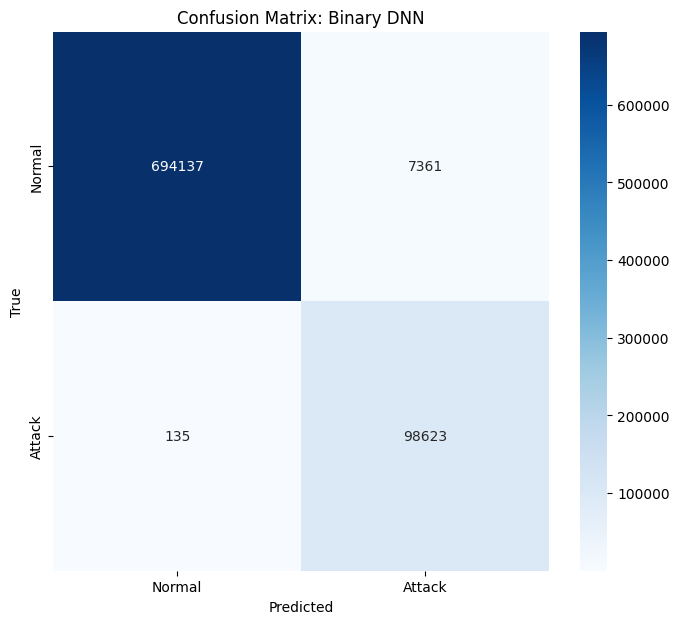

In [14]:
# binary_bal_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files, batch=False)
# features = []
# labels = []

# for x, y in binary_bal_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_dnn_model.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
bin_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary DNN')

### Results:

* Binary CNN-LSTM
    * Accuracy: 98.792%
    * Precision: 91.295%
    * Recall: 98.053%
    * F1 : 0.9455
    * Kappa: 0.9388
* Binary CNN-GRU
    * Accuracy: 98.952%
    * Precision: 91.447%
    * Recall: 99.505%
    * F1 : 0.9531
    * Kappa: 0.9472
* Binary Time Domain CNN
    * Accuracy: 95.407%
    * Precision: 89.891%
    * Recall: 64.270%
    * F1 : 0.7495
    * Kappa: 0.7250
* Binary 1D-CNN
    * Accuracy: 98.795%
    * Precision: 89.953%
    * Recall: 99.884%
    * F1 : 0.9466
    * Kappa: 0.9398
* Binary DNN
    * Accuracy: 98.393%
    * Precision: 89.714%
    * Recall: 95.974%
    * F1 : 0.9274
    * Kappa: 0.9184


In [15]:

from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model,
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

bin_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_arithmetic_mean_aggregate1.summary()

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, None, 1)   │          0 │ bin_CNN_LSTM[0][… │
│                     │                   │            │ binary_CNN_GRU[0… │
│                     │                   │            │ bin_TD_CNN[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,443 (75.95 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,443 (75.95 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Accuracy: 99.868%
Precision: 99.730%
Recall: 99.201%
F1 : 0.99465
Kappa: 0.99390


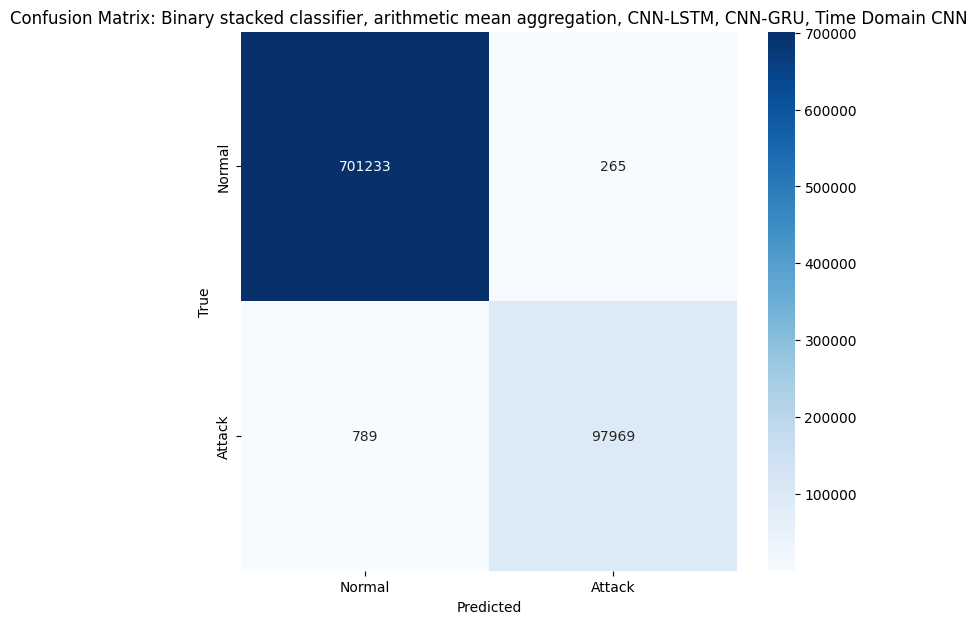

In [16]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_arithmetic_mean_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_arithmentic_mean_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregation, CNN-LSTM, CNN-GRU, Time Domain CNN')

In [17]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model,
]

bin_f1_weights = [
    bin_cnn_lstm_metrics[3],
    bin_cnn_gru_metrics[3],
    bin_td_cnn_metrics[3]
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print('F1 calculated_weights')
print(bin_f1_weights.numpy())

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate1 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate1.summary()

F1 calculated_weights
[0.37054637 0.30918777 0.32026586]


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[1][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[1… │
│                     │                   │            │ bin_TD_CNN[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 3)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, None, 3)   │          0 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,443 (75.95 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,443 (75.95 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Accuracy: 99.875%
Precision: 99.730%
Recall: 99.258%
F1 : 0.99494
Kappa: 0.99422


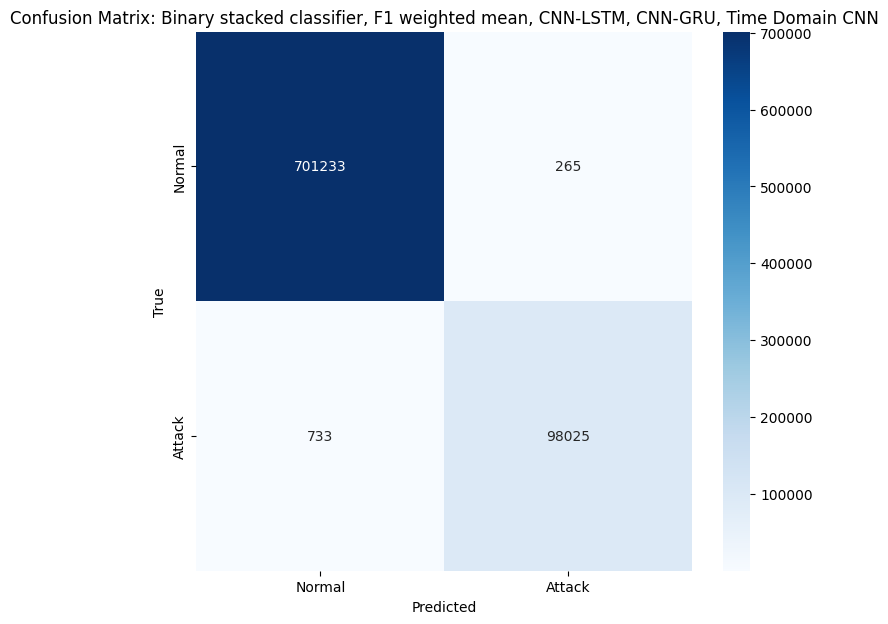

In [18]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
bin_f1_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, Time Domain CNN')

In [19]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)


bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print('Kappa score calculated weights')
print(bin_kappa_weights.numpy())

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate1.summary()

Kappa score calculated weights
[0.3659274  0.31217238 0.3219002 ]


Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[2][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[2… │
│                     │                   │            │ bin_TD_CNN[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, None, 3)   │          0 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,443 (75.95 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,443 (75.95 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Accuracy: 99.875%
Precision: 99.733%
Recall: 99.251%
F1 : 0.99491
Kappa: 0.99420


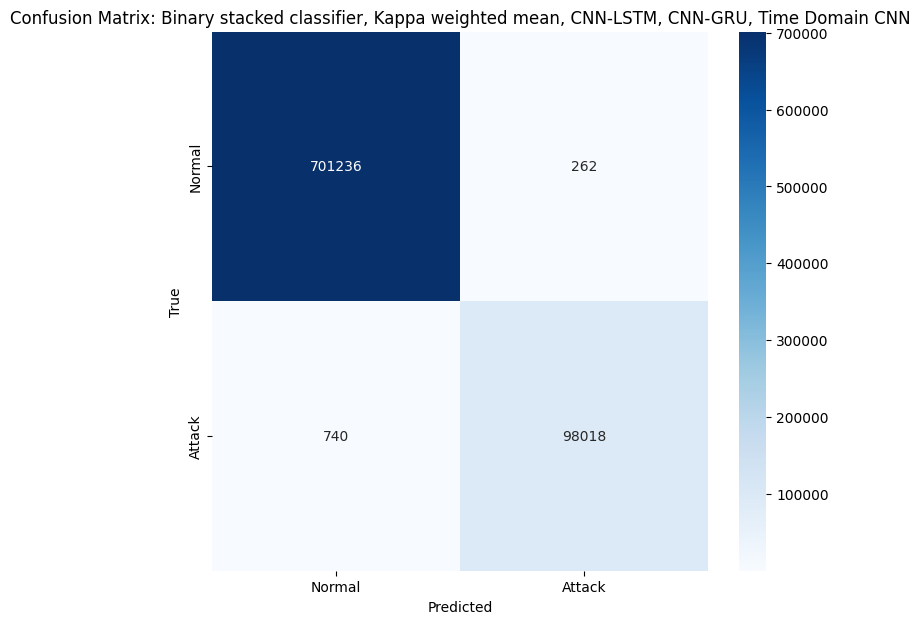

In [20]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
kappa_weighted_score1 = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU, Time Domain CNN')

In [21]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model
]


# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)


bin_stacked_log_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_stacked_log_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor1.summary()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[3][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[3… │
│                     │                   │            │ bin_TD_CNN[3][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 1)   │          4 │ concatenate_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,447 (75.96 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 19,443 (75.95 KB)

Epoch 1/4
    297/Unknown 74s 224ms/step - accuracy: 0.9986 - loss: 0.0072 - precision: 0.9942 - recall: 0.9938

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


298/298 ━━━━━━━━━━━━━━━━━━━━ 149s 476ms/step - accuracy: 0.9986 - loss: 0.0072 - precision: 0.9943 - recall: 0.9938 - val_accuracy: 0.9979 - val_loss: 0.0054 - val_precision: 0.9948 - val_recall: 0.9903
Epoch 2/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 127s 421ms/step - accuracy: 0.9981 - loss: 0.0045 - precision: 0.9884 - recall: 0.9959 - val_accuracy: 0.9978 - val_loss: 0.0039 - val_precision: 0.9950 - val_recall: 0.9898
Epoch 3/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 128s 423ms/step - accuracy: 0.9980 - loss: 0.0033 - precision: 0.9879 - recall: 0.9959 - val_accuracy: 0.9978 - val_loss: 0.0032 - val_precision: 0.9951 - val_recall: 0.9896
Epoch 4/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 127s 422ms/step - accuracy: 0.9982 - loss: 0.0027 - precision: 0.9889 - recall: 0.9956 - val_accuracy: 0.9978 - val_loss: 0.0027 - val_precision: 0.9951 - val_recall: 0.9896


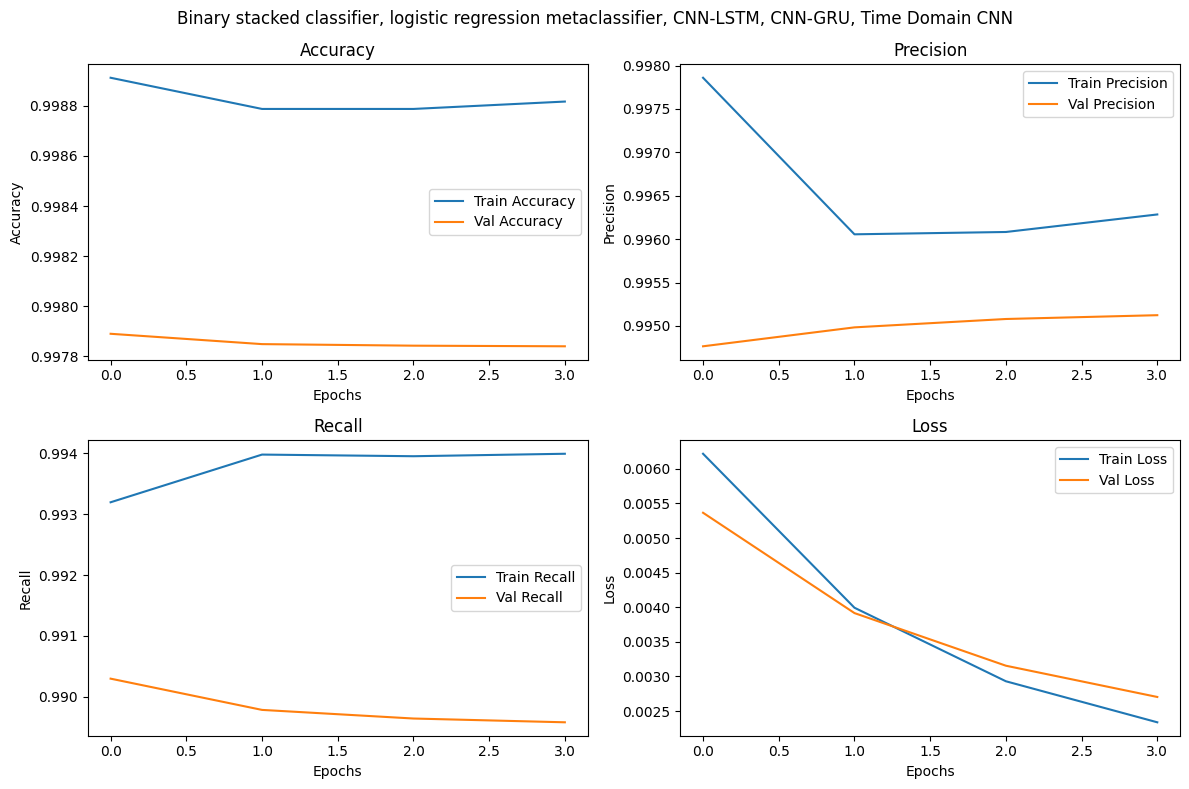

In [22]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)
history = bin_stacked_log_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, Time Domain CNN')

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Accuracy: 99.876%
Precision: 99.510%
Recall: 99.485%
F1 : 0.99497
Kappa: 0.99426


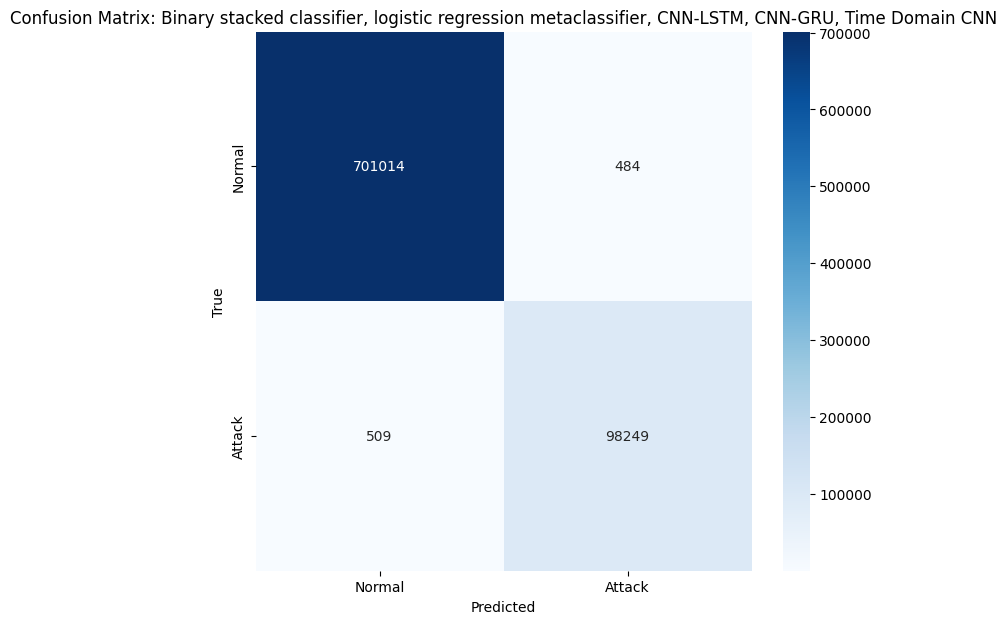

In [23]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_log_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
bin_stacked_log_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, CNN-LSTM, CNN-GRU, Time Domain CNN')

In [24]:
output_layer = bin_stacked_log_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[1.6701471]
 [1.6858757]
 [1.3850658]]
Logistic regressor bias:  [-2.2493393]


In [25]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model,
]

bin_kappa_weights = [
    bin_cnn_lstm_metrics[4],
    bin_cnn_gru_metrics[4],
    bin_td_cnn_metrics[4],
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-0.5)))(y)

bin_kappa_weighted_regressor1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_kappa_weighted_regressor1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor1.summary()

tf.Tensor([0.3659274  0.31217238 0.3219002 ], shape=(3,), dtype=float32)


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[5][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[5… │
│                     │                   │            │ bin_TD_CNN[5][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 1)   │          4 │ lambda_4[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,447 (75.96 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 19,443 (75.95 KB)

Epoch 1/4
    297/Unknown 59s 177ms/step - accuracy: 0.9984 - loss: 0.0658 - precision: 0.9932 - recall: 0.9932

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


298/298 ━━━━━━━━━━━━━━━━━━━━ 133s 426ms/step - accuracy: 0.9984 - loss: 0.0658 - precision: 0.9932 - recall: 0.9932 - val_accuracy: 0.9957 - val_loss: 0.0481 - val_precision: 0.9986 - val_recall: 0.9710
Epoch 2/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 127s 421ms/step - accuracy: 0.9985 - loss: 0.0426 - precision: 0.9987 - recall: 0.9889 - val_accuracy: 0.9950 - val_loss: 0.0340 - val_precision: 0.9989 - val_recall: 0.9660
Epoch 3/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 129s 426ms/step - accuracy: 0.9985 - loss: 0.0299 - precision: 0.9992 - recall: 0.9884 - val_accuracy: 0.9949 - val_loss: 0.0255 - val_precision: 0.9989 - val_recall: 0.9651
Epoch 4/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 128s 423ms/step - accuracy: 0.9985 - loss: 0.0222 - precision: 0.9994 - recall: 0.9884 - val_accuracy: 0.9950 - val_loss: 0.0199 - val_precision: 0.9989 - val_recall: 0.9657


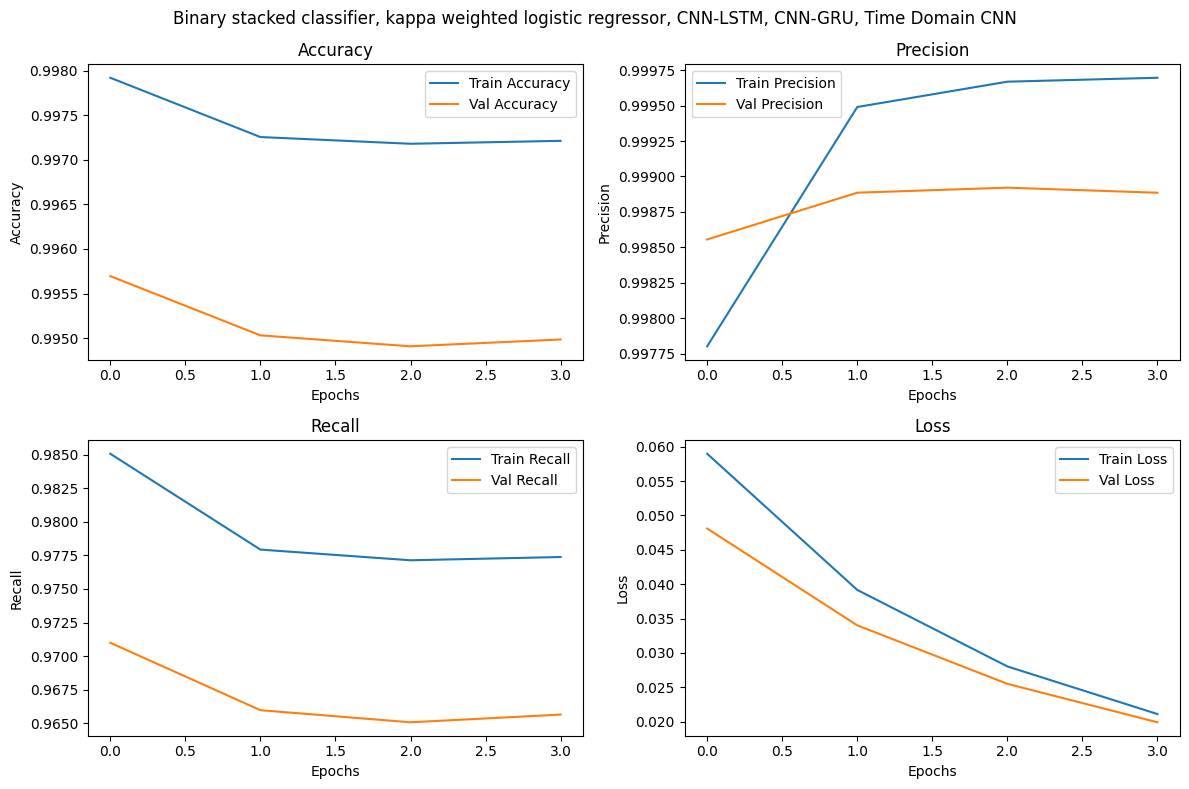

In [26]:

train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_kappa_weighted_regressor1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, kappa weighted logistic regressor, CNN-LSTM, CNN-GRU, Time Domain CNN')

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Accuracy: 99.700%
Precision: 99.935%
Recall: 97.632%
F1 : 0.98770
Kappa: 0.98599


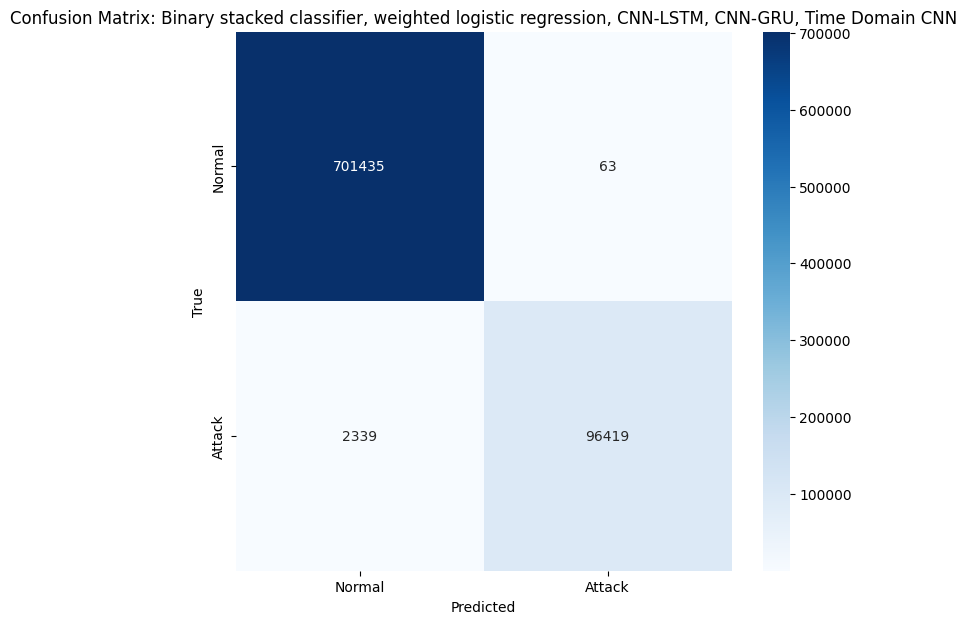

In [27]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
bin_kappa_weighted_regressor1_metics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression, CNN-LSTM, CNN-GRU, Time Domain CNN')

In [28]:
output_layer = bin_kappa_weighted_regressor1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.1064403]
 [1.9787855]
 [2.0588834]]
Logistic regressor bias:  [-1.2321534]


In [29]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate

input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    bin_cnn_lstm_model,
    bin_cnn_gru_model,
    bin_td_cnn_model,
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)


bin_stacked_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_stacked_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier1.summary()

Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_CNN_LSTM        │ (None, None, 1)   │     10,273 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, None, 3)   │          0 │ bin_CNN_LSTM[6][… │
│ (Concatenate)       │                   │            │ binary_CNN_GRU[6… │
│                     │                   │            │ bin_TD_CNN[6][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, None, 4)   │         16 │ concatenate_5[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,484 (76.11 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 19,443 (75.95 KB)

Epoch 1/4
    297/Unknown 62s 182ms/step - accuracy: 0.9986 - loss: 0.0036 - precision: 0.9999 - recall: 0.9884

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


298/298 ━━━━━━━━━━━━━━━━━━━━ 137s 435ms/step - accuracy: 0.9986 - loss: 0.0036 - precision: 0.9999 - recall: 0.9884 - val_accuracy: 0.9972 - val_loss: 0.0065 - val_precision: 0.9972 - val_recall: 0.9830
Epoch 2/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 168s 558ms/step - accuracy: 0.9986 - loss: 0.0040 - precision: 0.9952 - recall: 0.9928 - val_accuracy: 0.9978 - val_loss: 0.0060 - val_precision: 0.9954 - val_recall: 0.9892
Epoch 3/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 226s 754ms/step - accuracy: 0.9984 - loss: 0.0046 - precision: 0.9924 - recall: 0.9939 - val_accuracy: 0.9979 - val_loss: 0.0056 - val_precision: 0.9948 - val_recall: 0.9903
Epoch 4/4
298/298 ━━━━━━━━━━━━━━━━━━━━ 134s 441ms/step - accuracy: 0.9983 - loss: 0.0043 - precision: 0.9915 - recall: 0.9942 - val_accuracy: 0.9979 - val_loss: 0.0053 - val_precision: 0.9948 - val_recall: 0.9903


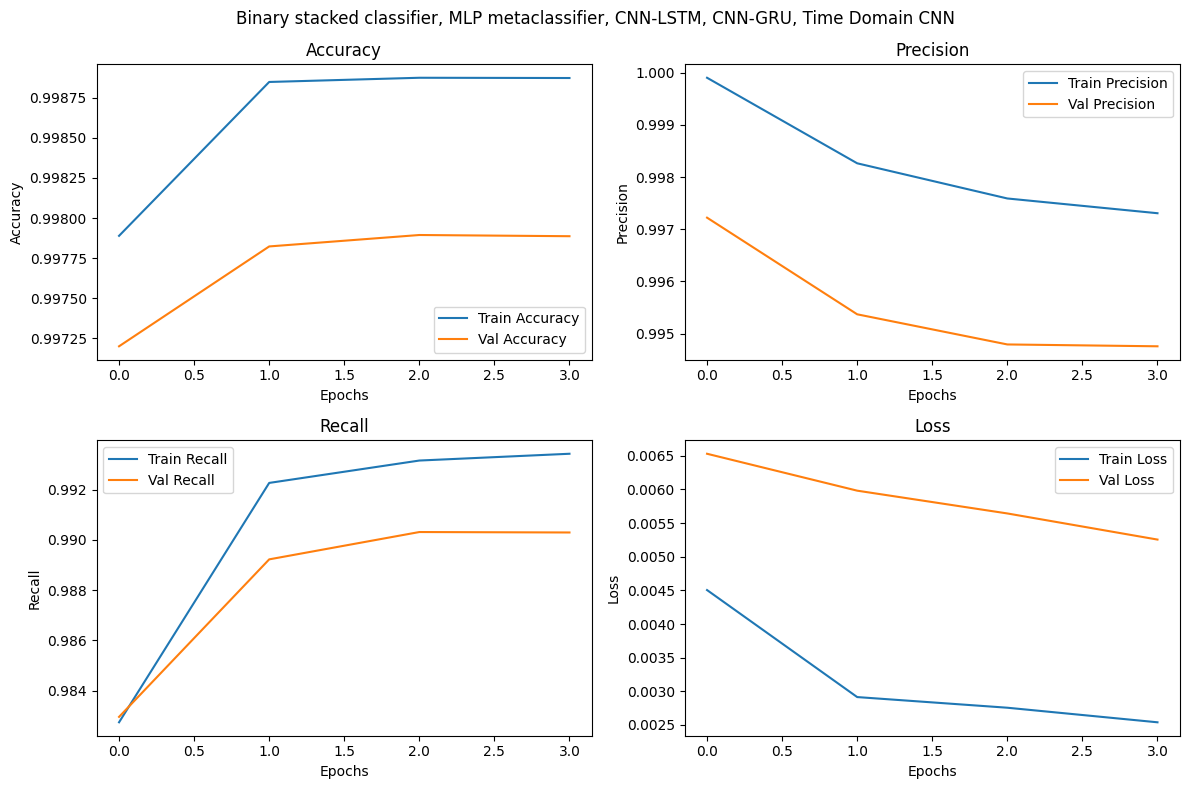

In [30]:
train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_stacked_dnn_classifier1.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, Time Domain CNN')

391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step
Accuracy: 99.878%
Precision: 99.478%
Recall: 99.535%
F1 : 0.99507
Kappa: 0.99437


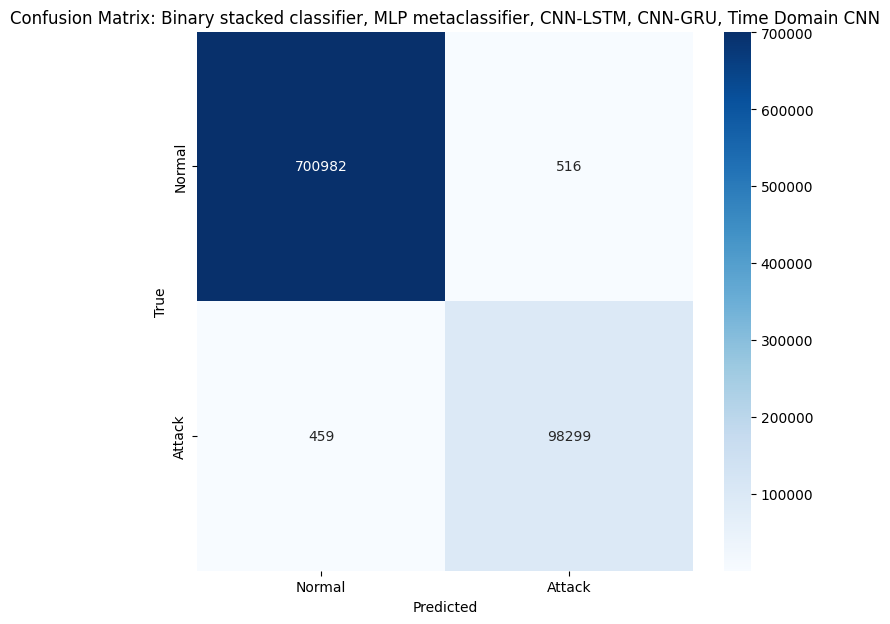

In [31]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier1.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
bin_stacked_dnn_classifier_metrics = score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, CNN-LSTM, CNN-GRU, Time Domain CNN')

### Top 3 Binary Models:

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| CNN-LSTM                   | 98.792%  | 91.295%   | 98.053% | 0.9455   | 0.9388  |
| CNN-GRU                    | 98.952%  | 91.447%   | 99.505% | 0.9531   | 0.9472  |
| 1D-CNN                     | 98.795%  | 89.953%   | 99.884% | 0.9466   | 0.9398  |
| Arithmetic mean            | 98.792%  | 90.027%   | 99.755% | 0.9464   | 0.9396  |
| Improvement from best      | -0.160%  | -1.420%   |  0.250% | -0.0067  | -0.0076 |
| F1 weighted mean           | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Kappa weighted mean        | 98.793%  | 90.032%   | 99.754% | 0.9464   | 0.9397  |
| Improvement from best      | -0.159%  | -1.415%   |  0.249% | -0.0067  | -0.0075 |
| Logistic regression        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Kappa weighted log. reg.   | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Improvement from best      | -0.174%  | -1.470%   |  0.279% | -0.0068  | -0.0073 |
| Stacked MLP                | 98.889%  | 87.903%   | 99.839% | 0.9349   | 0.9289  |
| Improvement from best      | -0.063%  | -3.550%   |  0.334% | -0.0182  | -0.0179 |




In [89]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_cnn_gru_model,
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    bc.trainable=False
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    for layer in bc.layers:

        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

bin_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

bin_arithmetic_mean_aggregate2.summary()

Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_42 │ (None, None, 1)   │      4,285 │ input_layer_17[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_43 │ (None, None, 1)   │      4,417 │ input_layer_17[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_17[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_4 (Average) │ (None, None, 1)   │          0 │ time_distributed… │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ binary_CNN_GRU[7… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,695 (53.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,695 (53.50 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step
Accuracy: 99.056%
Precision: 93.005%
Recall: 99.863%
F1 : 0.96312
Kappa: 0.95772


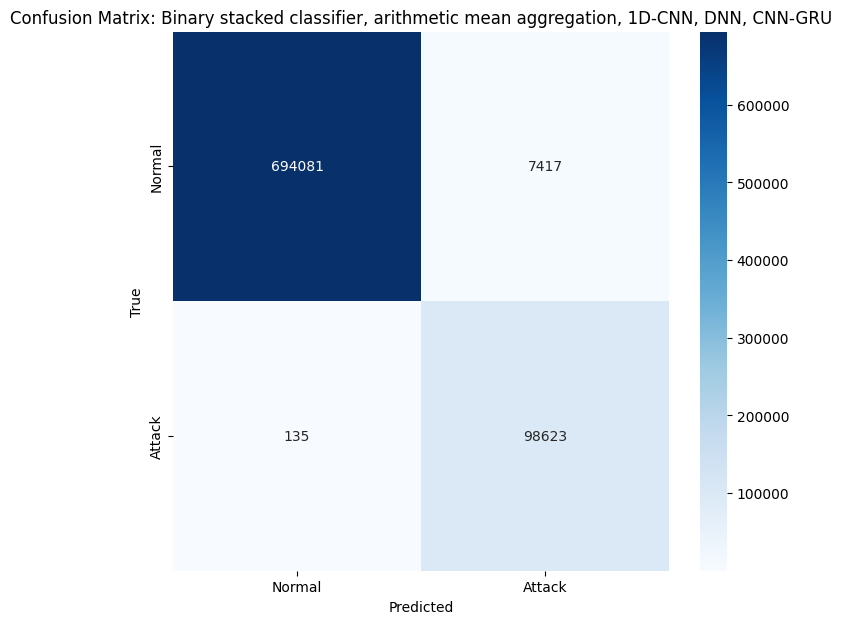

(0.9905630198336532,
 0.9300546963410034,
 0.9986330221349157,
 0.9631246398890614,
 0.9577216325164697)

In [90]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_true = labels.numpy().flatten()
y_pred = bin_arithmetic_mean_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, arithmetic mean aggregation, 1D-CNN, DNN, CNN-GRU')

In [91]:
import math
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_cnn_gru_model,
]


bin_f1_weights = [
    bin_cnn1d_metrics[3],
    bin_dnn_metrics[3],
    bin_cnn_gru_metrics[3],
]

bin_f1_weights = [math.log(w / (1 - w)) for w in bin_f1_weights]

sum_bin_f1_weights = sum(bin_f1_weights)

bin_f1_weights = tf.constant([w / sum_bin_f1_weights for w in bin_f1_weights], dtype=tf.float32)

print(bin_f1_weights)

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False    
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_f1_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_f1_weighted_aggregate2 = tf.keras.Model(input, y)


bin_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_f1_weighted_aggregate2.summary()

tf.Tensor([0.2880959  0.3210972  0.39080694], shape=(3,), dtype=float32)


Model: "functional_116"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, None, 1)   │      4,285 │ input_layer_18[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, None, 1)   │      4,417 │ input_layer_18[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ binary_CNN_GRU[8… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, None, 3)   │          0 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, None, 3)   │          0 │ lambda_22[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,695 (53.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 13,695 (53.50 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step
Accuracy: 99.059%
Precision: 93.026%
Recall: 99.862%
F1 : 0.96323
Kappa: 0.95784


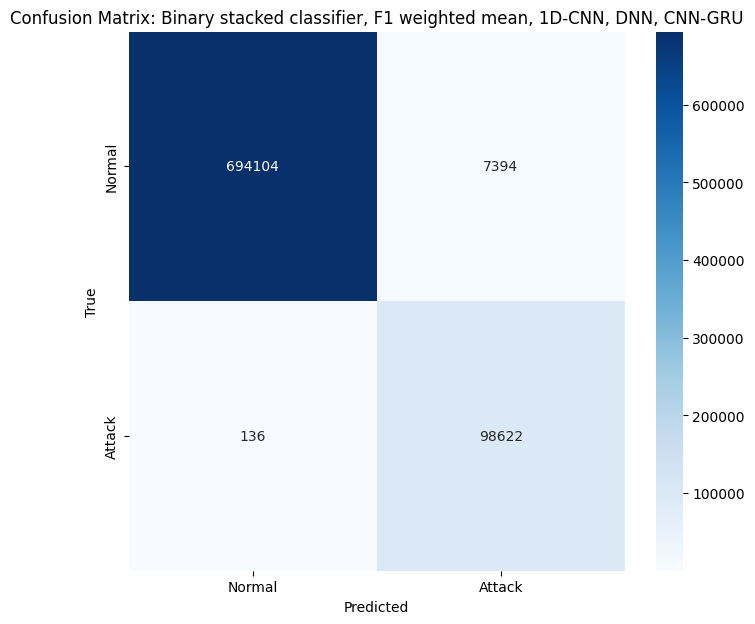

(0.9905905110364683,
 0.9302558104437066,
 0.9986228963729521,
 0.9632277535233965,
 0.9578405287126875)

In [92]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_f1_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, F1 weighted mean, 1D-CNN, DNN, CNN-GRU')

In [36]:
import math
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = tf.constant([w / sum_bin_kappa_weights for w in bin_kappa_weights], dtype=tf.float32)

print(bin_kappa_weights)
# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

bin_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

bin_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_aggregate2.summary()

tf.Tensor([0.29152226 0.31895915 0.3895186 ], shape=(3,), dtype=float32)


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, None, 1)   │      4,285 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, None, 1)   │      4,417 │ input_layer_7[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[9][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, None, 3)   │          0 │ lambda_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,879 (50.31 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,879 (50.31 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step
Accuracy: 99.060%
Precision: 93.032%
Recall: 99.860%
F1 : 0.96326
Kappa: 0.95787


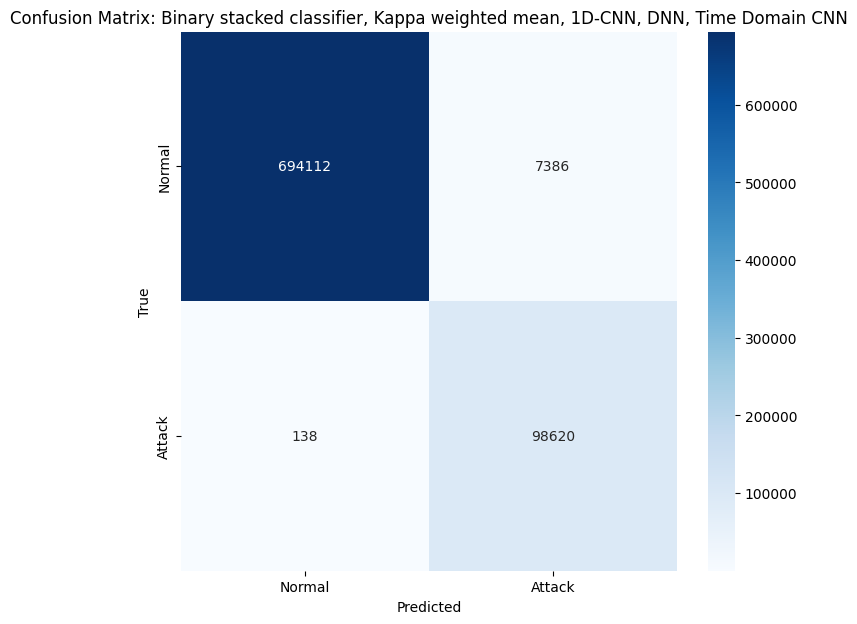

(0.9905980086372361,
 0.9303246986019659,
 0.9986026448490248,
 0.9632552597136216,
 0.9578723454033051)

In [37]:
# binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in binary_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_aggregate2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
# y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, Kappa weighted mean, 1D-CNN, DNN, Time Domain CNN')

In [93]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate
from keras.initializers import RandomNormal
input_shape = (None, n_features)
input = Input(input_shape)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_cnn_gru_model,
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)


bin_stacked_log_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_stacked_log_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_log_regressor2.summary()

Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_44 │ (None, None, 1)   │      4,285 │ input_layer_19[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_45 │ (None, None, 1)   │      4,417 │ input_layer_19[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ binary_CNN_GRU[9… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_46 │ (None, None, 1)   │          4 │ concatenate_18[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,699 (53.51 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 13,695 (53.50 KB)

Epoch 1/3
     73/Unknown 95s 1s/step - accuracy: 0.9936 - loss: 0.0036 - precision: 0.9452 - recall: 0.9988

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.9935 - loss: 0.0036 - precision: 0.9447 - recall: 0.9988 - val_accuracy: 0.9951 - val_loss: 0.0027 - val_precision: 0.9680 - val_recall: 0.9985
Epoch 2/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9939 - loss: 0.0029 - precision: 0.9477 - recall: 0.9988 - val_accuracy: 0.9955 - val_loss: 0.0027 - val_precision: 0.9712 - val_recall: 0.9980
Epoch 3/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9947 - loss: 0.0025 - precision: 0.9551 - recall: 0.9986 - val_accuracy: 0.9973 - val_loss: 0.0028 - val_precision: 0.9852 - val_recall: 0.9958


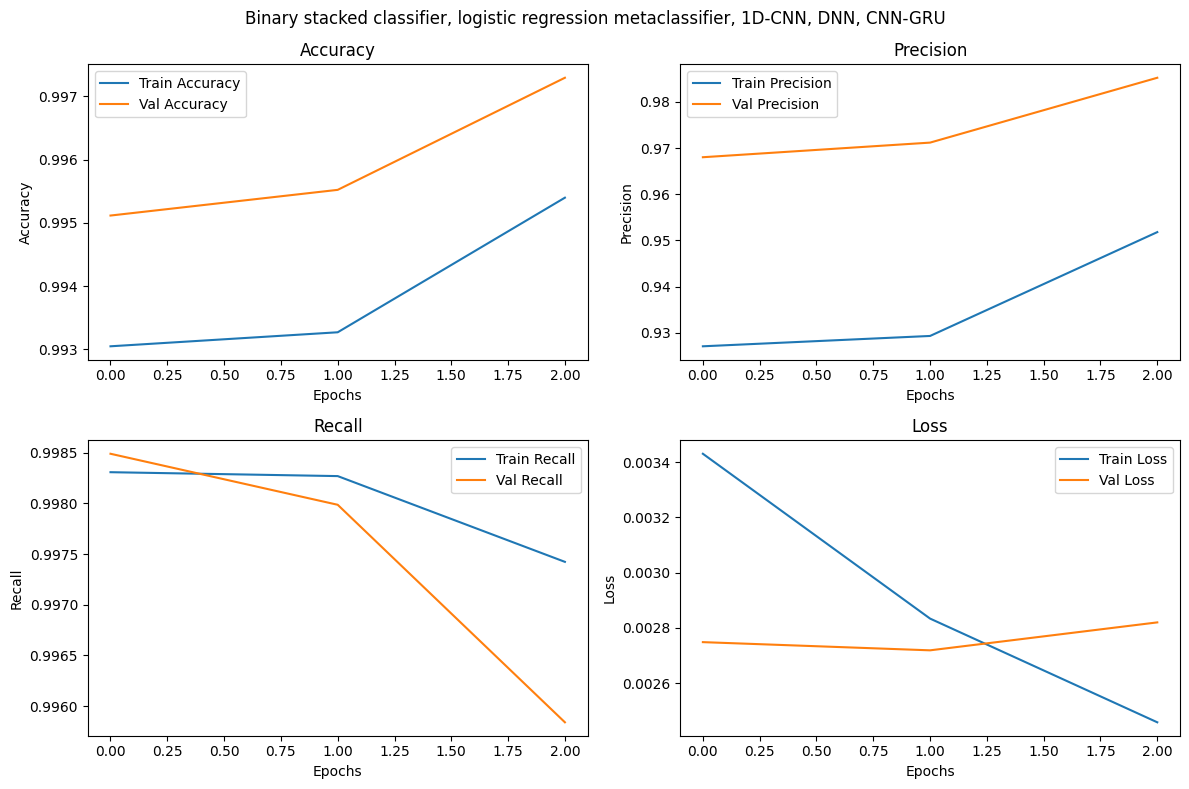

In [150]:

train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files, seq_length=256, seq_shift=256)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)
metaclassifier_epochs = 3
#tf.config.run_functions_eagerly(True)
history = bin_stacked_log_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)
#tf.config.run_functions_eagerly(False)
plot_model_history(history.history, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, CNN-GRU')

In [151]:
output_layer = bin_stacked_log_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[1.3253767]
 [1.263246 ]
 [2.6246295]]
Logistic regressor bias:  [-3.0648894]


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Accuracy: 99.658%
Precision: 97.960%
Recall: 99.297%
F1 : 0.98624
Kappa: 0.98429


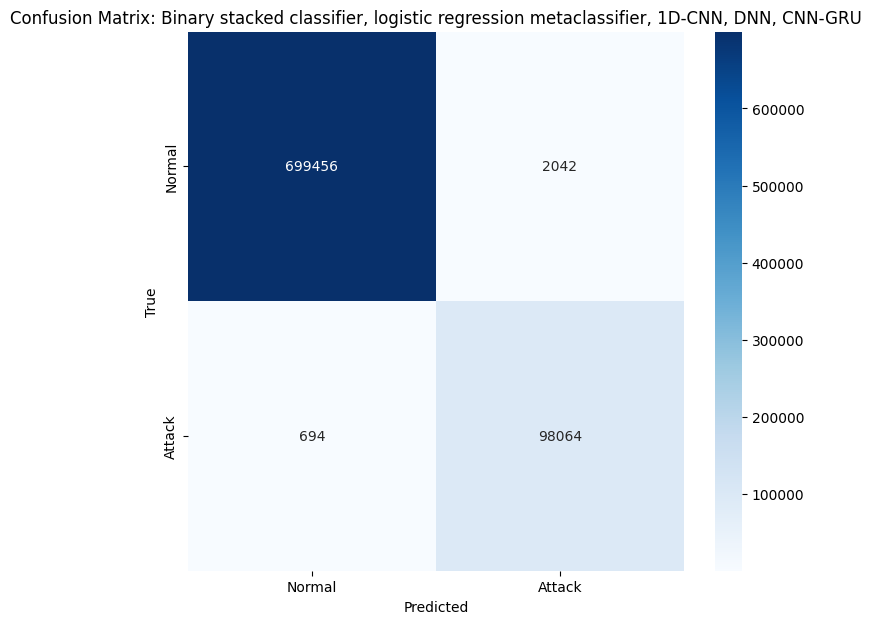

(0.996581094049904,
 0.9796016222803828,
 0.9929727211972701,
 0.9862418537291817,
 0.9842899681981264)

In [152]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_true = labels.numpy().flatten()
y_pred = bin_stacked_log_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, logistic regression metaclassifier, 1D-CNN, DNN, CNN-GRU')

In [42]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Lambda, Add
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_td_cnn_model,
]


bin_kappa_weights = [
    bin_cnn1d_metrics[4],
    bin_dnn_metrics[4],
    bin_td_cnn_metrics[4],
]

bin_kappa_weights = [math.log((1 + w) / (1 - w)) for w in bin_kappa_weights]

sum_bin_kappa_weights = sum(bin_kappa_weights)

bin_kappa_weights = [w / sum_bin_kappa_weights for w in bin_kappa_weights]

bin_kappa_weights = tf.constant(bin_kappa_weights, dtype=tf.float32)

print(bin_kappa_weights)

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = Lambda(lambda x: tf.multiply(x, bin_kappa_weights), output_shape=(None, 3))(combined_output)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-0.5)))(y)

bin_kappa_weighted_regressor2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_kappa_weighted_regressor2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_kappa_weighted_regressor2.summary()

tf.Tensor([0.29152226 0.31895915 0.3895186 ], shape=(3,), dtype=float32)


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, None, 1)   │      4,285 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, None, 1)   │      4,417 │ input_layer_9[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bin_TD_CNN          │ (None, None, 1)   │      4,177 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ bin_TD_CNN[11][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, None, 3)   │          0 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_12 │ (None, None, 1)   │          4 │ lambda_9[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,883 (50.32 KB)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 12,879 (50.31 KB)

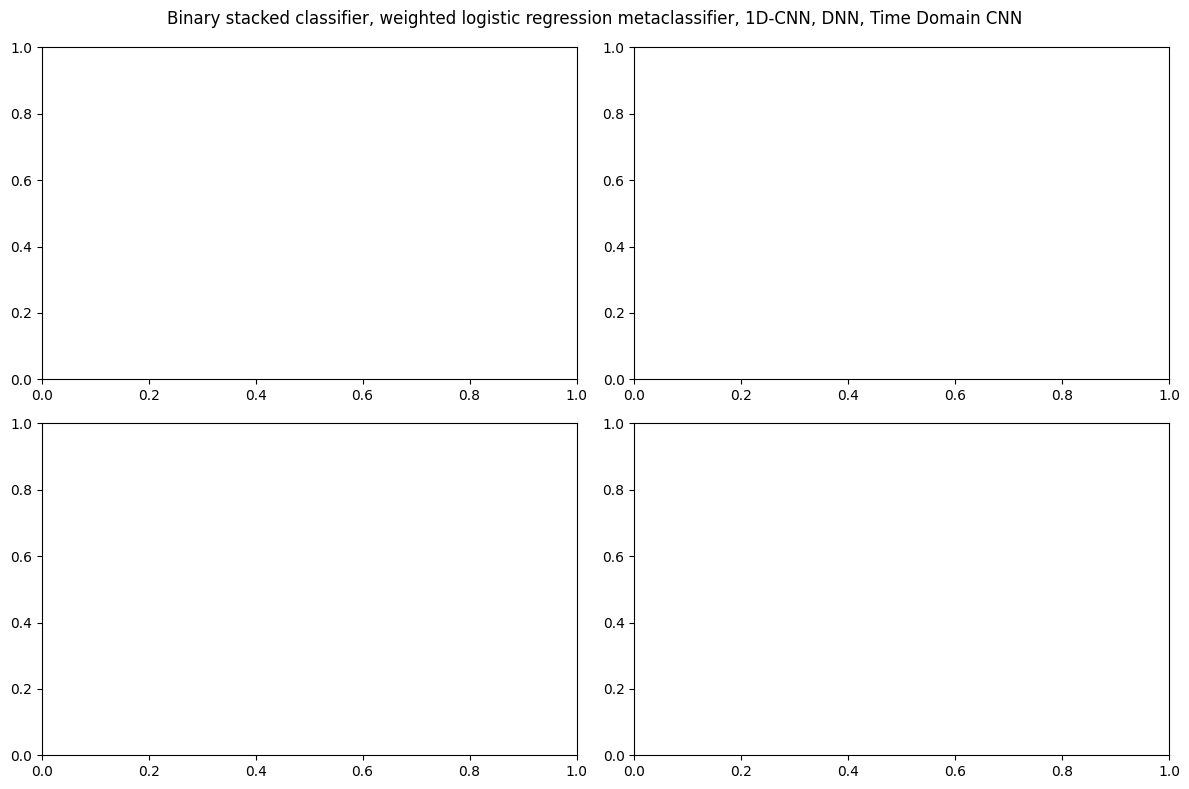

In [126]:

train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_kappa_weighted_regressor2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [44]:
output_layer = bin_kappa_weighted_regressor2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Logistic regressor weights:\n", output_weights)
print("Logistic regressor bias: ", output_bias)

Logistic regressor weights:
 [[2.1188407]
 [1.9859914]
 [1.993773 ]]
Logistic regressor bias:  [-1.2901388]


391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step
Accuracy: 99.712%
Precision: 98.083%
Recall: 99.611%
F1 : 0.98841
Kappa: 0.98676


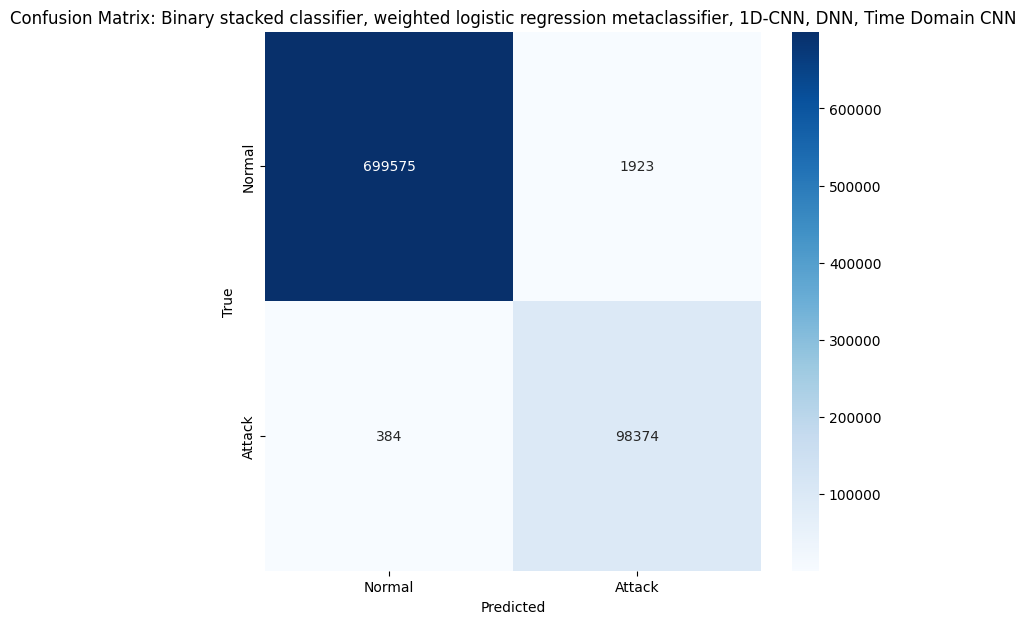

(0.9971171725047985,
 0.9808269439763901,
 0.9961117074059823,
 0.9884102383763281,
 0.9867642067752254)

In [45]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_kappa_weighted_regressor2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, weighted logistic regression metaclassifier, 1D-CNN, DNN, Time Domain CNN')

In [97]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate

td_bin_cnn1d_model = TimeDistributed(bin_cnn1d_model)
td_bin_dnn_model = TimeDistributed(bin_dnn_model)

bin_base_classifiers = [
    td_bin_cnn1d_model,
    td_bin_dnn_model,
    bin_cnn_gru_model,
]

# disabling training and dropout of base classifiers
for bc in bin_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in bin_base_classifiers]
combined_output = Concatenate()(base_classifiers_outputs)


y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-1.5)))(combined_output)
y = TimeDistributed(Dense(4, activation='relu', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)
y = TimeDistributed(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=1), bias_initializer=RandomNormal(mean=-2)))(y)


bin_stacked_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

bin_stacked_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'binary_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

bin_stacked_dnn_classifier2.summary()

Model: "functional_118"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_47 │ (None, None, 1)   │      4,285 │ input_layer_19[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_48 │ (None, None, 1)   │      4,417 │ input_layer_19[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_CNN_GRU      │ (None, None, 1)   │      4,993 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, None, 3)   │          0 │ time_distributed… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ binary_CNN_GRU[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_49 │ (None, None, 4)   │         16 │ concatenate_19[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_50 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_51 │ (None, None, 1)   │          5 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,736 (53.66 KB)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 13,695 (53.50 KB)

Epoch 1/2
    211/Unknown 100s 450ms/step - accuracy: 0.9946 - loss: 0.0035 - precision: 0.9628 - recall: 0.9880

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


211/211 ━━━━━━━━━━━━━━━━━━━━ 174s 806ms/step - accuracy: 0.9946 - loss: 0.0035 - precision: 0.9628 - recall: 0.9878 - val_accuracy: 0.9972 - val_loss: 0.0026 - val_precision: 0.9884 - val_recall: 0.9922
Epoch 2/2
211/211 ━━━━━━━━━━━━━━━━━━━━ 169s 779ms/step - accuracy: 0.9957 - loss: 0.0026 - precision: 0.9723 - recall: 0.9867 - val_accuracy: 0.9973 - val_loss: 0.0026 - val_precision: 0.9880 - val_recall: 0.9927


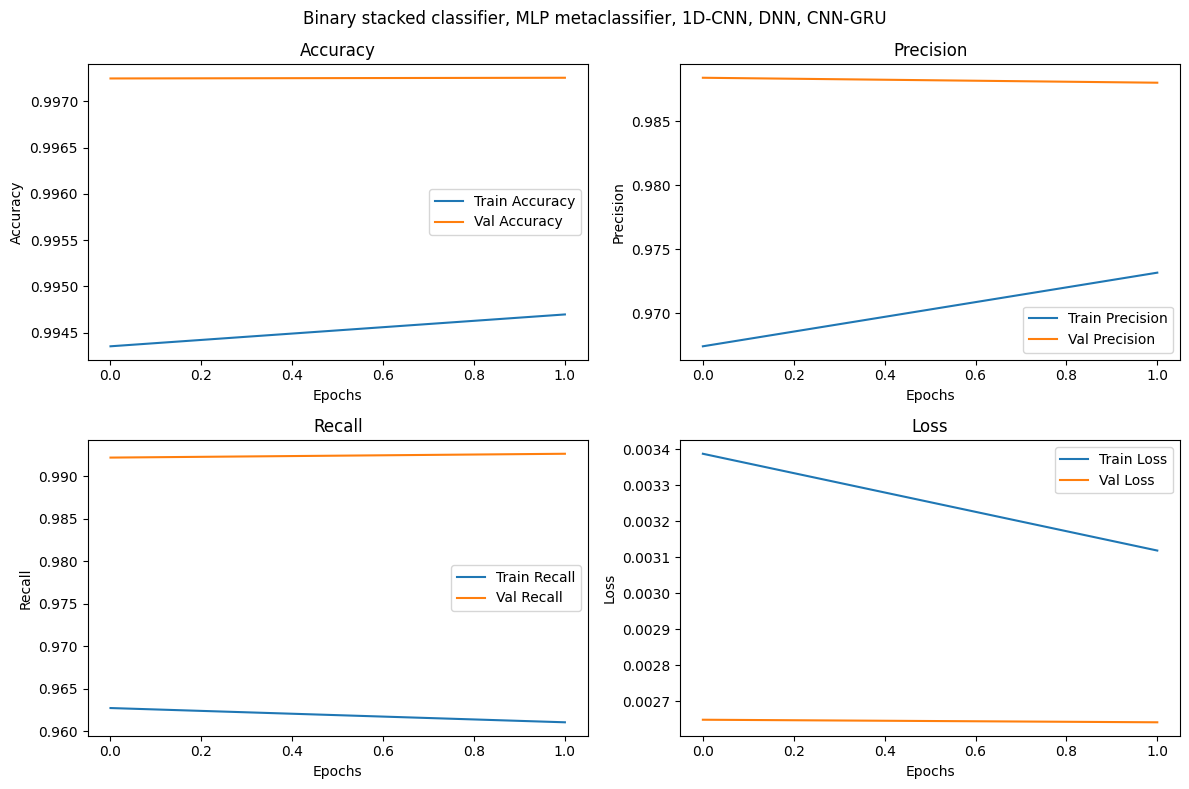

In [175]:

train_bin_seq_ds = data_utils.create_binary_sequential_dataset(train_seq_files, seq_length=144, seq_shift=144)
val_bin_seq_ds = data_utils.create_binary_sequential_dataset(val_seq_files)

history = bin_stacked_dnn_classifier2.fit(
    train_bin_seq_ds,
    validation_data = val_bin_seq_ds,
    epochs = metaclassifier_epochs,
)

plot_model_history(history.history, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, CNN-GRU')

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Accuracy: 99.668%
Precision: 98.277%
Recall: 99.043%
F1 : 0.98659
Kappa: 0.98469


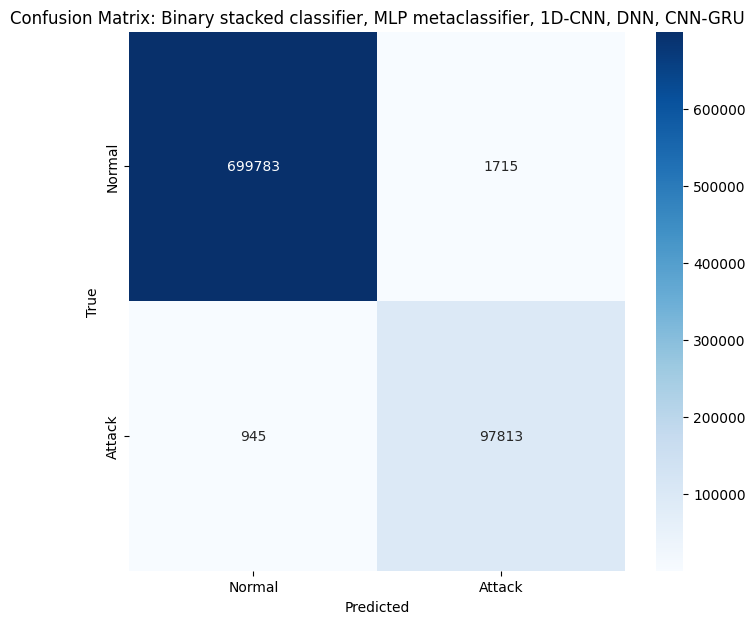

(0.9966760636596289,
 0.9827686681134957,
 0.9904311549444096,
 0.9865850337391445,
 0.9846880825947161)

In [176]:
binary_sequential_test_ds = data_utils.create_binary_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in binary_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)

y_pred = bin_stacked_dnn_classifier2.predict(features)
y_pred = (y_pred > 0.5).astype(int).flatten()
y_true = labels.numpy().flatten()
    
score_and_confusion_matrix(y_pred, y_true, 'Binary stacked classifier, MLP metaclassifier, 1D-CNN, DNN, CNN-GRU')

### Bottom 3 binary models

| Model                      | Accuracy | Precision | Recall  | F1       | Kappa   |
|----------------------------|----------|-----------|---------|----------|---------|
| Time Domain CNN            | 95.407%  | 89.891%   | 64.270% | 0.7495   | 0.7250  |
| 1D-CNN                     | 98.795%  | 89.954%   | 99.884% | 0.9466   | 0.9398  |
| DNN                        | 98.788%  | 89.977%   | 99.784% | 0.9463   | 0.9395  |
| Arithmetic mean            | 98.824%  | 90.328%   | 99.671% | 0.9477   | 0.9411  |
| Improvement from best      |  0.029%  |  0.374%   | -0.213% | 0.0011   | 0.0013  |
| F1 weighted mean           | 98.788%  | 89.964%   | 99.686% | 0.9458   | 0.9389  |
| Improvement from best      |  0.000%  |  0.010%   | -0.198% | -0.0008  | -0.0007 |
| Kappa weighted mean        | 98.784%  | 90.014%   | 99.683% | 0.9460   | 0.9392  |
| Improvement from best      | -0.004%  |  0.060%   | -0.201% | -0.0006  | -0.0004 |
| Logistic regression        | 98.791%  | 90.069%   | 99.683% | 0.9463   | 0.9395  |
| Improvement from best      |  0.003%  |  0.155%   | -0.201% | -0.0003  | -0.0001 |

In [49]:
import multiclass_cnn_lstm
import data_utils

mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()

if not mul_cnn_lstm_model.built:
    model = mul_cnn_lstm_model
    model.fit(
            data_utils.create_multiclass_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_bal_files),
            epochs = 6,
        )
    history = model.fit(
            data_utils.create_multiclass_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_seq_files),
            epochs = 6,
            callbacks = multiclass_cnn_lstm.checkpoint_callback,
        )
    history = history.history
    
    plot_model_history(history, "Multiclass CNN-LSTM")
    print(history)
    #loading best checkpoint
    mul_cnn_lstm_model = multiclass_cnn_lstm.multiclass_CNN_LSTM_model()
    
mul_cnn_lstm_model.name = 'mul_CNN-LSTM'    
mul_cnn_lstm_model.summary()


Model loaded from saved_models/multiclass_cnn_lstm.keras


Model: "mul_CNN-LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 24)       │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 16)       │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 3)        │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,099 (113.67 KB)

 Trainable params: 9,699 (37.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,400 (75.79 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Accuracy: 99.706%
Precision: 98.848%
Recall: 99.660%
F1 : 0.99247
Kappa: 0.98695


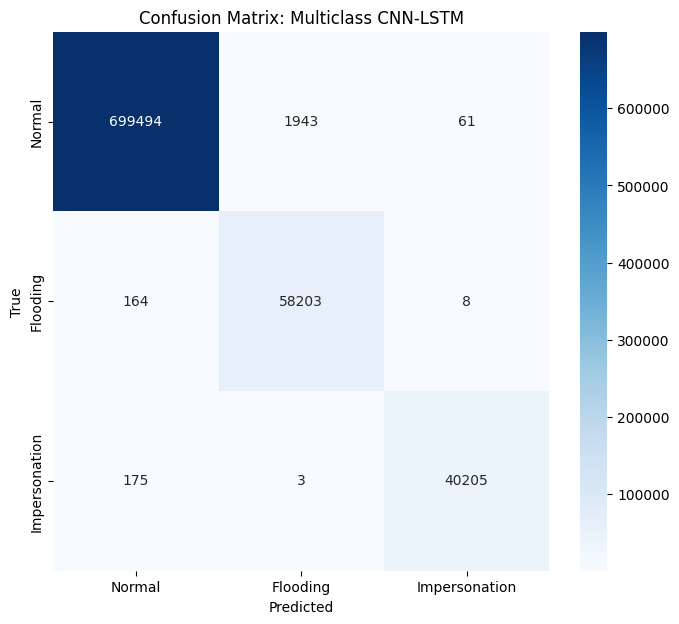

In [50]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_lstm_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_lstm_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-LSTM", binary=False, average='macro')


In [51]:
import multiclass_cnn_gru
import data_utils

mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU_model()

if not mul_cnn_gru_model.built:
    model = mul_cnn_gru_model
    model.fit(
            data_utils.create_multiclass_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_bal_files),
            epochs = 6,
        )
    history = model.fit(
            data_utils.create_multiclass_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_seq_files),
            epochs = 6,
            callbacks = multiclass_cnn_gru.checkpoint_callback,
        )
    history = history.history
    plot_model_history(history, "Multiclass CNN-GRU")
    print(history)
    #loading best checkpoint
    mul_cnn_gru_model = multiclass_cnn_gru.multiclass_CNN_GRU()
    
mul_cnn_gru_model.name = 'mul_CNN-GRU'    
mul_cnn_gru_model.summary()


Model loaded from saved_models/multiclass_cnn_gru.keras


Model: "mul_CNN-GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 24)       │         2,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 24)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 16)       │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_dense (TimeDistributed)      │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ td_output (TimeDistributed)     │ (None, None, 3)        │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,035 (58.73 KB)

 Trainable params: 5,011 (19.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,024 (39.16 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Accuracy: 99.661%
Precision: 98.852%
Recall: 99.410%
F1 : 0.99127
Kappa: 0.98494


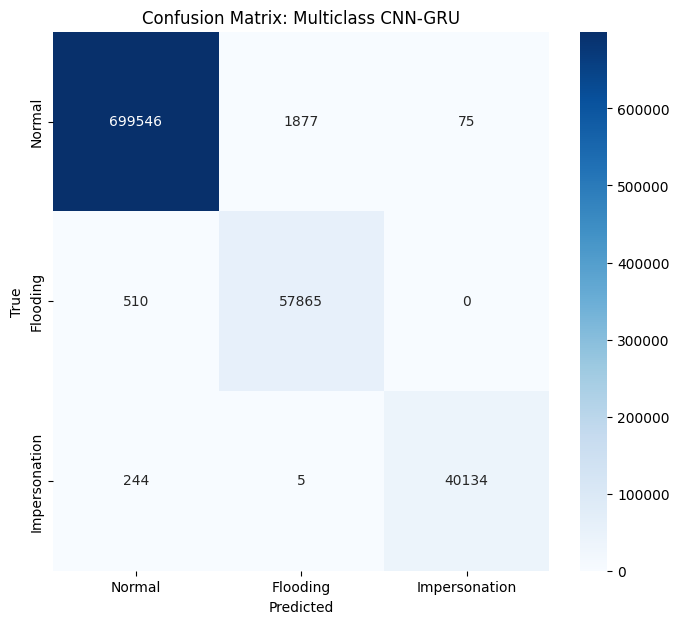

In [52]:
#multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
#features = []
#labels = []
#
#for x, y in multiclass_sequential_test_ds:
#    features.append(x)
#    labels.append(y)
#
#features = tf.concat(features, axis=0)
#labels = tf.concat(labels, axis=0)
y_pred = mul_cnn_gru_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
#y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_cnn_gru_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass CNN-GRU", binary=False, average='macro')


In [53]:
import multiclass_td_cnn
import data_utils

mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()

if not mul_td_cnn_model.built:
    model = mul_td_cnn_model
    model.fit(
            data_utils.create_multiclass_sequential_dataset(train_bal_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_bal_files),
            epochs = 10,
        )
    history = model.fit(
            data_utils.create_multiclass_sequential_dataset(train_seq_files),
            validation_data = data_utils.create_multiclass_sequential_dataset(val_seq_files),
            epochs = 6,
            callbacks = multiclass_td_cnn.checkpoint_callback,
        )
    history = history.history
    plot_model_history(history, "Multiclass Time-Domain CNN")
    print(history)
    #loading best checkpoint
    mul_td_cnn_model = multiclass_td_cnn.multiclass_time_domain_CNN_model()
    
    
mul_td_cnn_model.summary()


Model loaded from saved_models/multiclass_td_cnn.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 16)       │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, None, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, None, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 3)        │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,907 (42.61 KB)

 Trainable params: 3,603 (14.07 KB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 7,208 (28.16 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 99.096%
Precision: 99.560%
Recall: 95.599%
F1 : 0.97488
Kappa: 0.95829


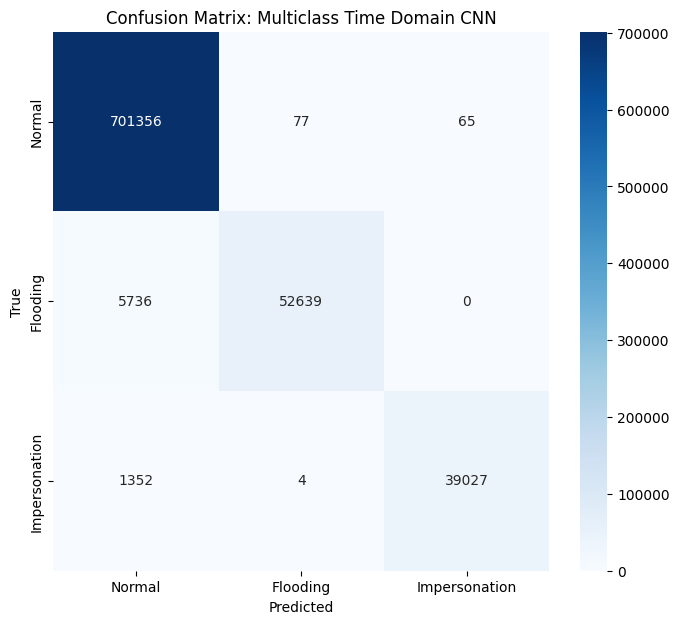

In [54]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_td_cnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_td_cnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass Time Domain CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_cnn1d.keras


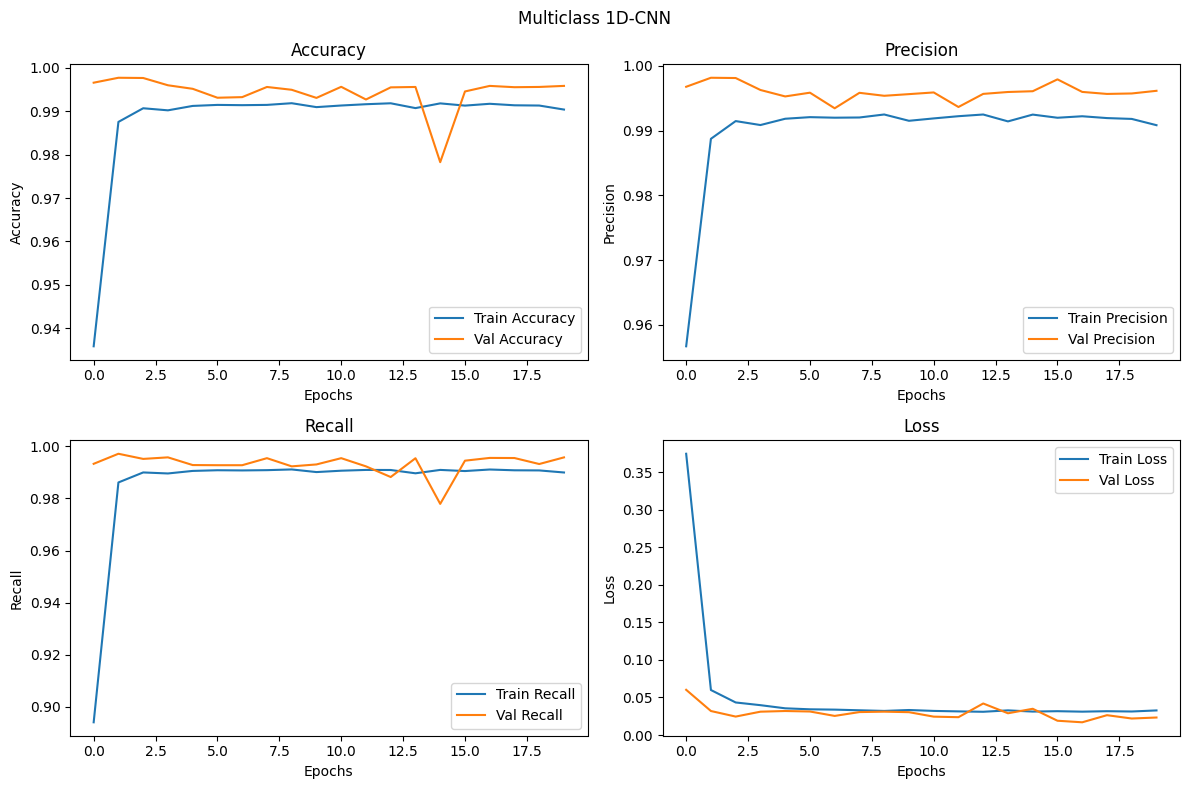

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 39, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 39, 24)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 24)         │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 12)         │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 39, 12)         │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 39, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 468)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         3,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,735 (49.75 KB)

 Trainable params: 4,215 (16.46 KB)

 Non-trainable params: 88 (352.00 B)

 Optimizer params: 8,432 (32.94 KB)

In [55]:
import multiclass_cnn1d
import data_utils

mul_cnn1d_model = multiclass_cnn1d.multiclass_CNN1D_model()

if not mul_cnn1d_model.built:
    mul_bal_train_ds = data_utils.create_multiclass_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_multiclass_dataset(val_bal_files)
    history = mul_cnn1d_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=20,
            callbacks = [multiclass_cnn1d.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass 1D-CNN')
else:
    history = {'accuracy': [0.9358255863189697, 0.9875490665435791, 0.990696370601654, 0.9902184009552002, 0.9912344813346863, 0.9914701581001282, 0.9914084076881409, 0.9914718270301819, 0.9918603301048279, 0.9909580945968628, 0.9913303852081299, 0.9916278719902039, 0.9918440580368042, 0.9907321333885193, 0.9918213486671448, 0.9913076162338257, 0.9917270541191101, 0.9913791418075562, 0.9913238883018494, 0.9903972744941711], 'loss': [0.3746308982372284, 0.05995461344718933, 0.043375641107559204, 0.039770279079675674, 0.03559455648064613, 0.03427198901772499, 0.03384455665946007, 0.03296022489666939, 0.0321054644882679, 0.03332914784550667, 0.03212638944387436, 0.03148769214749336, 0.030973292887210846, 0.03284872695803642, 0.031241169199347496, 0.031754299998283386, 0.031129447743296623, 0.03173844516277313, 0.03134065121412277, 0.03277812525629997], 'precision': [0.9566869139671326, 0.9887308478355408, 0.9914689064025879, 0.9908571839332581, 0.991828978061676, 0.9920764565467834, 0.9919919371604919, 0.9920234680175781, 0.9924874901771545, 0.991513729095459, 0.9918813109397888, 0.992222785949707, 0.9924842715263367, 0.9914208650588989, 0.9924715757369995, 0.9919835925102234, 0.9922143220901489, 0.9919326305389404, 0.9918031096458435, 0.9908348321914673], 'recall': [0.89397794008255, 0.9861526489257812, 0.9899989366531372, 0.9896088242530823, 0.9905858039855957, 0.9908459186553955, 0.9907727837562561, 0.9908784627914429, 0.9911515712738037, 0.9901419878005981, 0.9906687140464783, 0.990967869758606, 0.9909402132034302, 0.9896705746650696, 0.9909727573394775, 0.9905354380607605, 0.9911288022994995, 0.990826427936554, 0.9907776713371277, 0.9899843335151672], 'val_accuracy': [0.9965909123420715, 0.9977272748947144, 0.9976736903190613, 0.9959959387779236, 0.9951812028884888, 0.9931228756904602, 0.9932622313499451, 0.9956046342849731, 0.9949560165405273, 0.9930853247642517, 0.9956421256065369, 0.9927154779434204, 0.9955134987831116, 0.9956046342849731, 0.9782696962356567, 0.9945701360702515, 0.9958512187004089, 0.9955510497093201, 0.9956099987030029, 0.9958512187004089], 'val_loss': [0.06023438647389412, 0.031986743211746216, 0.024582514539361, 0.031100505962967873, 0.03199338912963867, 0.03133712336421013, 0.02546389028429985, 0.030568471178412437, 0.03112155571579933, 0.030443701893091202, 0.02448367513716221, 0.023774661123752594, 0.04201584309339523, 0.02898300811648369, 0.03496921434998512, 0.019040048122406006, 0.016965271905064583, 0.02643703855574131, 0.021996933966875076, 0.02333533950150013], 'val_precision': [0.9967673420906067, 0.998159646987915, 0.9981184601783752, 0.99627286195755, 0.9952768087387085, 0.9958544969558716, 0.9934454560279846, 0.995833694934845, 0.9953761100769043, 0.9956309199333191, 0.9958924055099487, 0.993645191192627, 0.9956687688827515, 0.9959617257118225, 0.9960798621177673, 0.997913122177124, 0.9959729313850403, 0.995663046836853, 0.9957333207130432, 0.9961446523666382], 'val_recall': [0.9933158159255981, 0.9971805214881897, 0.9952026009559631, 0.9957975745201111, 0.9928387403488159, 0.9927797913551331, 0.9927797913551331, 0.9954867362976074, 0.9923402667045593, 0.9930745959281921, 0.9954867362976074, 0.9923402667045593, 0.9882397055625916, 0.9954599142074585, 0.9779159426689148, 0.9945218563079834, 0.995583176612854, 0.9955403208732605, 0.9932354092597961, 0.9957869052886963]}
    plot_model_history(history, 'Multiclass 1D-CNN')

mul_cnn1d_model.summary()



25008/25008 ━━━━━━━━━━━━━━━━━━━━ 21s 827us/step
Accuracy: 98.975%
Precision: 96.000%
Recall: 99.222%
F1 : 0.97516
Kappa: 0.95557


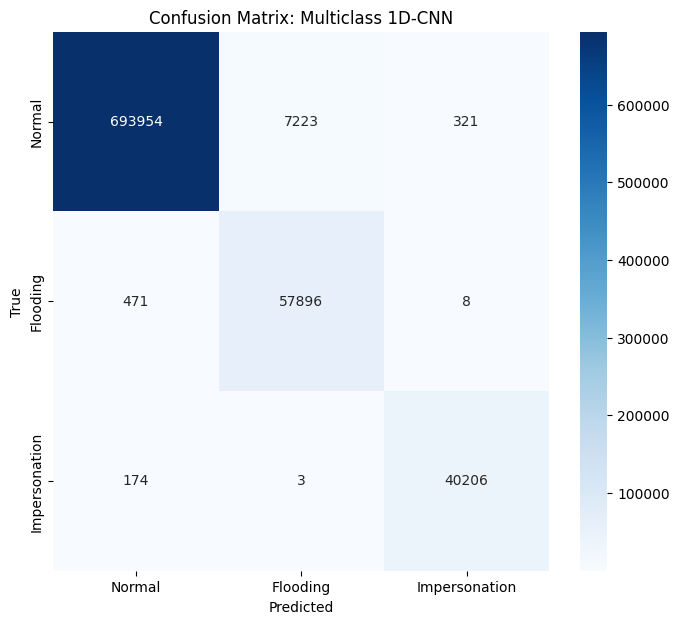

In [56]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_true = tf.argmax(labels, axis=1).numpy().flatten()
y_pred = mul_cnn1d_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
    
mul_cnn1d_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass 1D-CNN", binary=False, average='macro')


Model loaded from saved_models/multiclass_dnn.keras


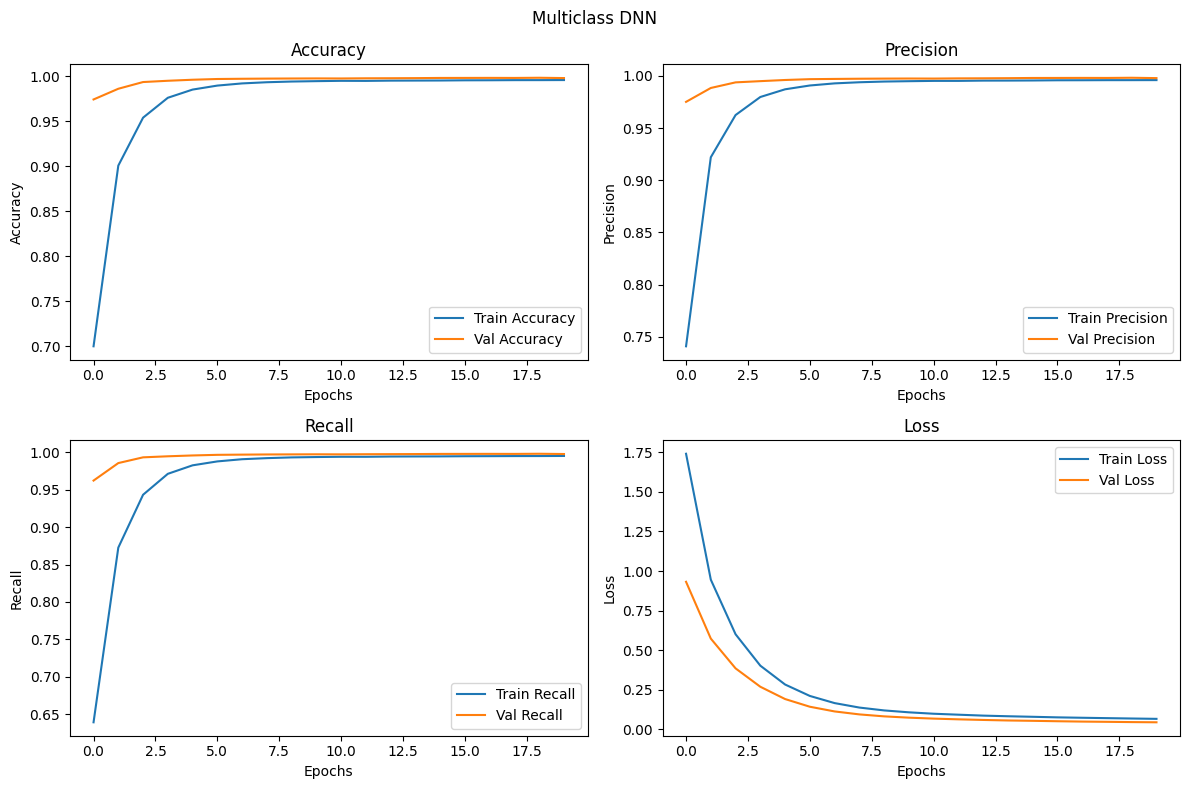

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,971 (50.67 KB)

 Trainable params: 4,259 (16.64 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 8,520 (33.29 KB)

In [57]:
import multiclass_dnn
import data_utils

mul_dnn_model = multiclass_dnn.multiclass_DNN_model()

if not mul_dnn_model.built:
    mul_bal_train_ds = data_utils.create_multiclass_dataset(train_bal_files)
    mul_bal_val_ds = data_utils.create_multiclass_dataset(val_bal_files)
    history = mul_dnn_model.fit(
            mul_bal_train_ds,
            validation_data = mul_bal_val_ds,
            epochs=20,
            callbacks = [multiclass_dnn.checkpoint_callback],
        )
    
    plot_model_history(history.history, 'Multiclass DNN')
else:
    history = {'accuracy': [0.6998798847198486, 0.9005562663078308, 0.9538034796714783, 0.9759027361869812, 0.9850084781646729, 0.989441454410553, 0.9918545484542847, 0.9931626915931702, 0.9939417243003845, 0.9943729043006897, 0.9947280287742615, 0.9946549534797668, 0.9949429035186768, 0.995017409324646, 0.995089054107666, 0.9953053593635559, 0.9953667521476746, 0.9954953789710999, 0.9955099821090698, 0.9955859780311584], 'loss': [1.740508794784546, 0.9457042813301086, 0.6010504364967346, 0.40275025367736816, 0.28375244140625, 0.21163536608219147, 0.16647487878799438, 0.13825613260269165, 0.12022668123245239, 0.10821527242660522, 0.0992577001452446, 0.09327483177185059, 0.08742690086364746, 0.08340086042881012, 0.08000269532203674, 0.0763908103108406, 0.0738903284072876, 0.07148801535367966, 0.06914404034614563, 0.06699945777654648], 'precision': [0.7408876419067383, 0.921977162361145, 0.9624151587486267, 0.9796997904777527, 0.9870744347572327, 0.9907275438308716, 0.9927496910095215, 0.993828296661377, 0.9945005178451538, 0.9948509335517883, 0.9951395988464355, 0.9951408505439758, 0.9954046607017517, 0.9954386353492737, 0.9955307841300964, 0.9957312345504761, 0.9957680106163025, 0.9958369731903076, 0.9958546161651611, 0.9958915710449219], 'recall': [0.6389783024787903, 0.8726136088371277, 0.9432902932167053, 0.9712972640991211, 0.9826684594154358, 0.9879053235054016, 0.9908343553543091, 0.9922783970832825, 0.9932693839073181, 0.9937472939491272, 0.9941127300262451, 0.9940761923789978, 0.994438648223877, 0.9945380091667175, 0.9946213364601135, 0.9948332905769348, 0.9949253797531128, 0.9950393438339233, 0.9950729608535767, 0.995204508304596], 'val_accuracy': [0.9740244150161743, 0.9859187602996826, 0.9933801293373108, 0.9947952628135681, 0.9959369897842407, 0.9967517256736755, 0.9970089793205261, 0.9971912503242493, 0.9973145127296448, 0.9974056482315063, 0.9973466992378235, 0.9975396394729614, 0.9976093769073486, 0.9977272748947144, 0.9979309439659119, 0.9979577660560608, 0.9980006217956543, 0.9979363083839417, 0.9981346726417542, 0.997791588306427], 'val_loss': [0.9322057366371155, 0.5736573338508606, 0.38569435477256775, 0.26963600516319275, 0.19203844666481018, 0.14350955188274384, 0.11381589621305466, 0.09508626163005829, 0.08270341157913208, 0.07448885589838028, 0.06849800050258636, 0.06395645439624786, 0.060077909380197525, 0.05671093612909317, 0.05455091968178749, 0.05194412171840668, 0.04974689707159996, 0.0482216477394104, 0.04651651158928871, 0.0452493280172348], 'val_precision': [0.9750430583953857, 0.988347589969635, 0.9937208294868469, 0.9948909878730774, 0.9959954023361206, 0.9967836141586304, 0.9970142245292664, 0.9972019195556641, 0.9973251819610596, 0.9974056482315063, 0.9973520040512085, 0.9975396394729614, 0.9976146817207336, 0.9977433085441589, 0.9979309439659119, 0.9979577660560608, 0.9980006217956543, 0.997957706451416, 0.9981346726417542, 0.9977969527244568], 'val_recall': [0.9622748494148254, 0.9856775403022766, 0.9933480024337769, 0.9947469830513, 0.9958672523498535, 0.9966981410980225, 0.9969714879989624, 0.9971912503242493, 0.9972984790802002, 0.9974056482315063, 0.9973413348197937, 0.9975182414054871, 0.9976093769073486, 0.9977272748947144, 0.9979202151298523, 0.9979577660560608, 0.9979952573776245, 0.9979363083839417, 0.9981346726417542, 0.9977862238883972]}
    plot_model_history(history, 'Multiclass DNN')

mul_dnn_model.summary()



25008/25008 ━━━━━━━━━━━━━━━━━━━━ 17s 675us/step
Accuracy: 99.057%
Precision: 96.165%
Recall: 99.537%
F1 : 0.97743
Kappa: 0.95917


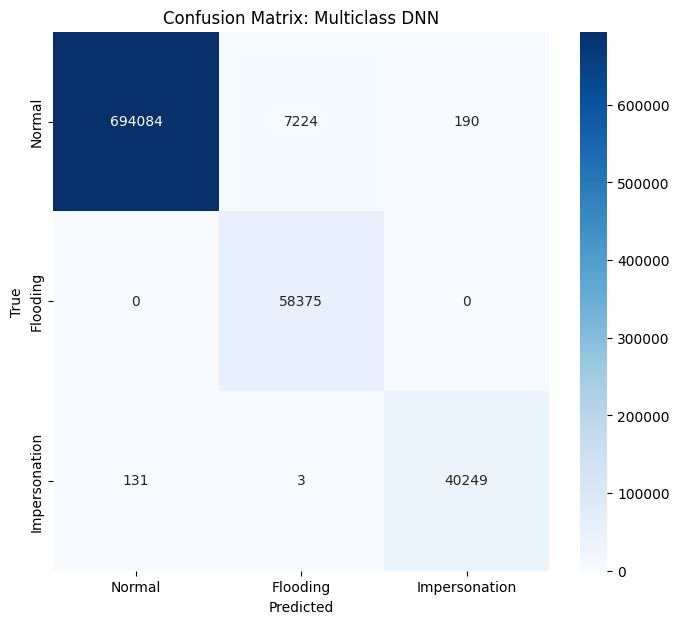

In [58]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files, batch=False)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
# y_true = tf.argmax(labels, axis=1).numpy().flatten()
y_pred = mul_dnn_model.predict(features)
y_pred = tf.argmax(y_pred, axis=1).numpy().flatten()
    
mul_dnn_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass DNN", binary=False, average='macro')


### Multiclass Models performance

* CNN-LSTM
    * Accuracy: 99.238%
    * Precision: 96.198%
    * Recall: 99.089%
    * F1 : 0.9754
    * Kappa: 0.9509
* CNN-GRU
    * Accuracy: 99.032%
    * Precision: 94.927%
    * Recall: 99.077%
    * F1 : 0.9684
    * Kappa: 0.9384
* Time Domain CNN
    * Accuracy: 96.971%
    * Precision: 78.809%
    * Recall: 69.121%
    * F1 : 0.7053
    * Kappa: 0.7790
* 1D-CNN
    * Accuracy: 98.807%
    * Precision: 93.063%
    * Recall: 99.281%
    * F1 : 0.9593
    * Kappa: 0.9253
* DNN
    * Accuracy: 98.873%
    * Precision: 94.268%
    * Recall: 99.370%
    * F1 : 0.9659
    * Kappa: 0.9292


In [59]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_arithmetic_mean_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate1.summary()

Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      9,699 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      5,011 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, None, 3)   │      4,451 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_2 (Average) │ (None, None, 3)   │          0 │ mul_CNN-LSTM[0][… │
│                     │                   │            │ mul_CNN-GRU[0][0… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,161 (74.85 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,161 (74.85 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
Accuracy: 99.068%
Precision: 96.248%
Recall: 99.537%
F1 : 0.97784
Kappa: 0.95965


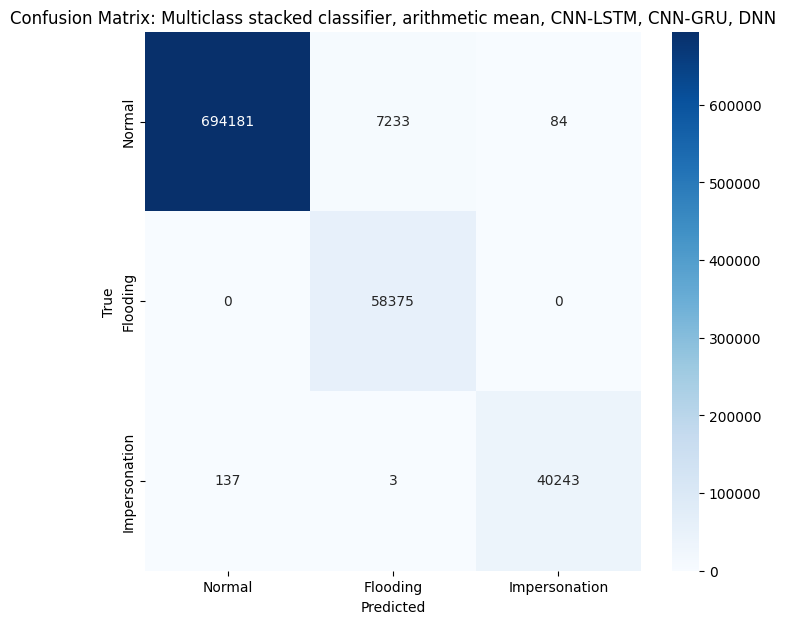

In [60]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    features.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_arithmetic_mean_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [61]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

mul_f1_weights = [
    mul_cnn_lstm_metrics[3],
    mul_cnn_gru_metrics[3],
    mul_dnn_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_f1_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate1.summary()

F1 calculated_weights
[[0.3647515 ]
 [0.35362592]
 [0.2816226 ]]


Model: "functional_106"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      9,699 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      5,011 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_18 │ (None, None, 3)   │      4,451 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, None, 3,   │          0 │ mul_CNN-LSTM[0][… │
│                     │ 3)                │            │ mul_CNN-GRU[0][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, None, 3)   │          0 │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, None, 3)   │          0 │ lambda_11[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,161 (74.85 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,161 (74.85 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
Accuracy: 99.070%
Precision: 96.269%
Recall: 99.526%
F1 : 0.97789
Kappa: 0.95970


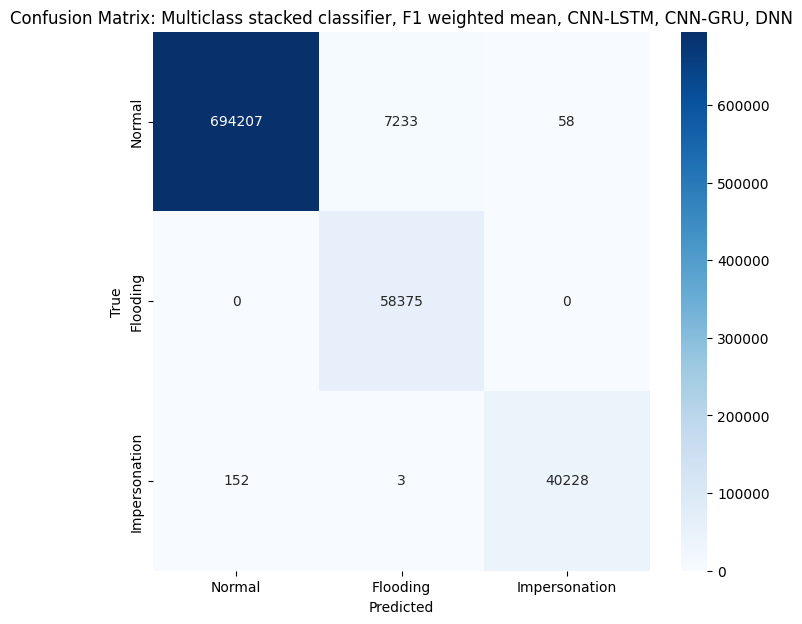

In [62]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [63]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

mul_kappa_weights = [
    mul_cnn_lstm_metrics[4],
    mul_cnn_gru_metrics[4],
    mul_dnn_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())


base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_kappa_weighted_aggregate1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate1.summary()

Cohe Kappa calculated_weights
[[0.37089676]
 [0.35843575]
 [0.2706675 ]]


Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      9,699 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      5,011 │ input_layer_10[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_20 │ (None, None, 3)   │      4,451 │ input_layer_10[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, None, 3,   │          0 │ mul_CNN-LSTM[1][… │
│                     │ 3)                │            │ mul_CNN-GRU[1][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, None, 3)   │          0 │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, None, 3)   │          0 │ lambda_14[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,161 (74.85 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19,161 (74.85 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
Accuracy: 99.069%
Precision: 96.271%
Recall: 99.520%
F1 : 0.97787
Kappa: 0.95968


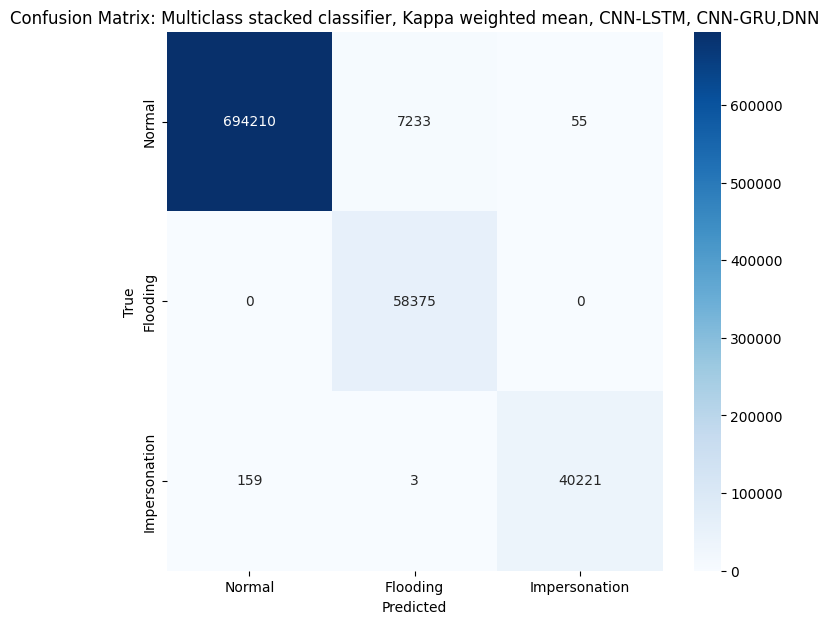

In [64]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, CNN-LSTM, CNN-GRU,DNN", binary=False, average='macro')

In [65]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomUniform
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_softmax_regression1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_softmax_regression1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression1.summary()

Model: "functional_108"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      9,699 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      5,011 │ input_layer_11[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_21 │ (None, None, 3)   │      4,451 │ input_layer_11[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, None, 9)   │          0 │ mul_CNN-LSTM[2][… │
│ (Concatenate)       │                   │            │ mul_CNN-GRU[2][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_22 │ (None, None, 3)   │         30 │ concatenate_12[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,191 (74.96 KB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 19,161 (74.85 KB)

Epoch 1/3
    172/Unknown 103s 555ms/step - accuracy: 0.9950 - loss: 6.7762e-04 - precision: 0.9952 - recall: 0.9949

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


172/172 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9951 - loss: 6.7648e-04 - precision: 0.9952 - recall: 0.9949 - val_accuracy: 0.9966 - val_loss: 6.6638e-04 - val_precision: 0.9969 - val_recall: 0.9964
Epoch 2/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9970 - loss: 4.4521e-04 - precision: 0.9973 - recall: 0.9968 - val_accuracy: 0.9965 - val_loss: 7.0804e-04 - val_precision: 0.9968 - val_recall: 0.9963
Epoch 3/3
172/172 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9981 - loss: 3.8153e-04 - precision: 0.9982 - recall: 0.9978 - val_accuracy: 0.9964 - val_loss: 7.2610e-04 - val_precision: 0.9967 - val_recall: 0.9963


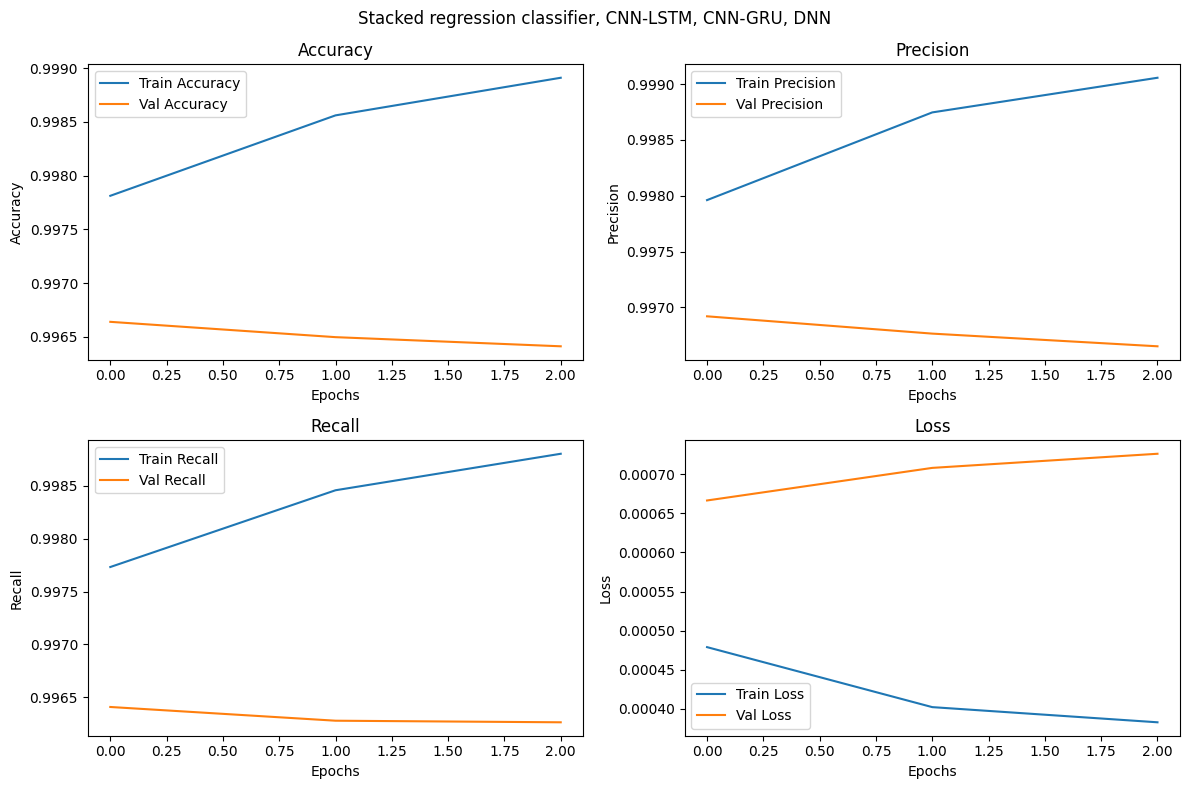

In [154]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files, seq_length=128, seq_shift=128)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_softmax_regression1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Stacked regression classifier, CNN-LSTM, CNN-GRU, DNN')

In [155]:
output_layer = mul_softmax_regression1.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

Softmax regressor weights:
 [[ 1.3911195  -1.6807466  -0.04847614]
 [-0.5323018   0.2862008  -0.24075626]
 [-1.5407486  -0.47107518  1.2284682 ]
 [ 0.9180511  -0.63820267 -0.8111328 ]
 [-0.58621424 -0.08795132 -0.7511338 ]
 [-0.14486282 -0.7043355   0.5702471 ]
 [ 0.4333604  -0.11616373  0.20390016]
 [-0.17923698  0.98086214 -1.6099559 ]
 [-1.0765556  -0.53872275  0.09971301]]
Softmax regressor bias:  [ 0.36502168  0.48131153 -0.47267267]


391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Accuracy: 99.836%
Precision: 99.495%
Recall: 99.642%
F1 : 0.99568
Kappa: 0.99270


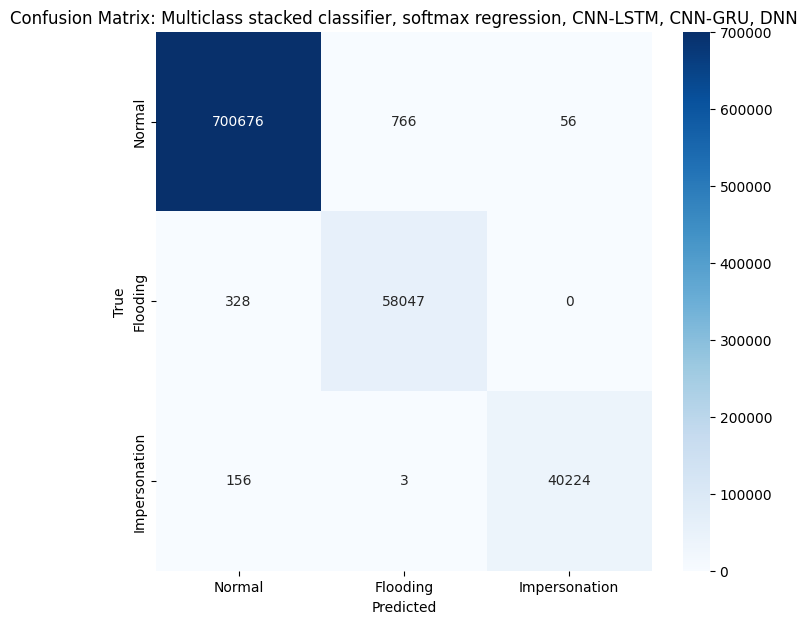

In [156]:
multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
features = []
labels = []

for x, y in multiclass_sequential_test_ds:
    featuriies.append(x)
    labels.append(y)

features = tf.concat(features, axis=0)
labels = tf.concat(labels, axis=0)
y_pred = mul_softmax_regression1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_softmax_regression1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression, CNN-LSTM, CNN-GRU, DNN", binary=False, average='macro')

In [69]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Dense
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

mul_base_classifiers = [
    mul_cnn_lstm_model,
    mul_cnn_gru_model,
    td_mul_dnn_model,
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier1 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_dnn_classifier1.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier1.summary()

Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-LSTM        │ (None, None, 3)   │      9,699 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mul_CNN-GRU         │ (None, None, 3)   │      5,011 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_23 │ (None, None, 3)   │      4,451 │ input_layer_12[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, None, 9)   │          0 │ mul_CNN-LSTM[3][… │
│ (Concatenate)       │                   │            │ mul_CNN-GRU[3][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_24 │ (None, None, 4)   │         40 │ concatenate_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_25 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_26 │ (None, None, 3)   │         15 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,236 (75.14 KB)

 Trainable params: 75 (300.00 B)

 Non-trainable params: 19,161 (74.85 KB)

Epoch 1/3
    231/Unknown 166s 675ms/step - accuracy: 0.9966 - loss: 6.5855e-04 - precision: 0.9966 - recall: 0.9965

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


231/231 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9966 - loss: 6.5835e-04 - precision: 0.9966 - recall: 0.9965 - val_accuracy: 0.9967 - val_loss: 7.0056e-04 - val_precision: 0.9968 - val_recall: 0.9966
Epoch 2/3
231/231 ━━━━━━━━━━━━━━━━━━━━ 233s 988ms/step - accuracy: 0.9990 - loss: 3.3285e-04 - precision: 0.9991 - recall: 0.9990 - val_accuracy: 0.9965 - val_loss: 7.2457e-04 - val_precision: 0.9966 - val_recall: 0.9964
Epoch 3/3
231/231 ━━━━━━━━━━━━━━━━━━━━ 220s 933ms/step - accuracy: 0.9989 - loss: 3.4660e-04 - precision: 0.9989 - recall: 0.9988 - val_accuracy: 0.9964 - val_loss: 7.5219e-04 - val_precision: 0.9966 - val_recall: 0.9963


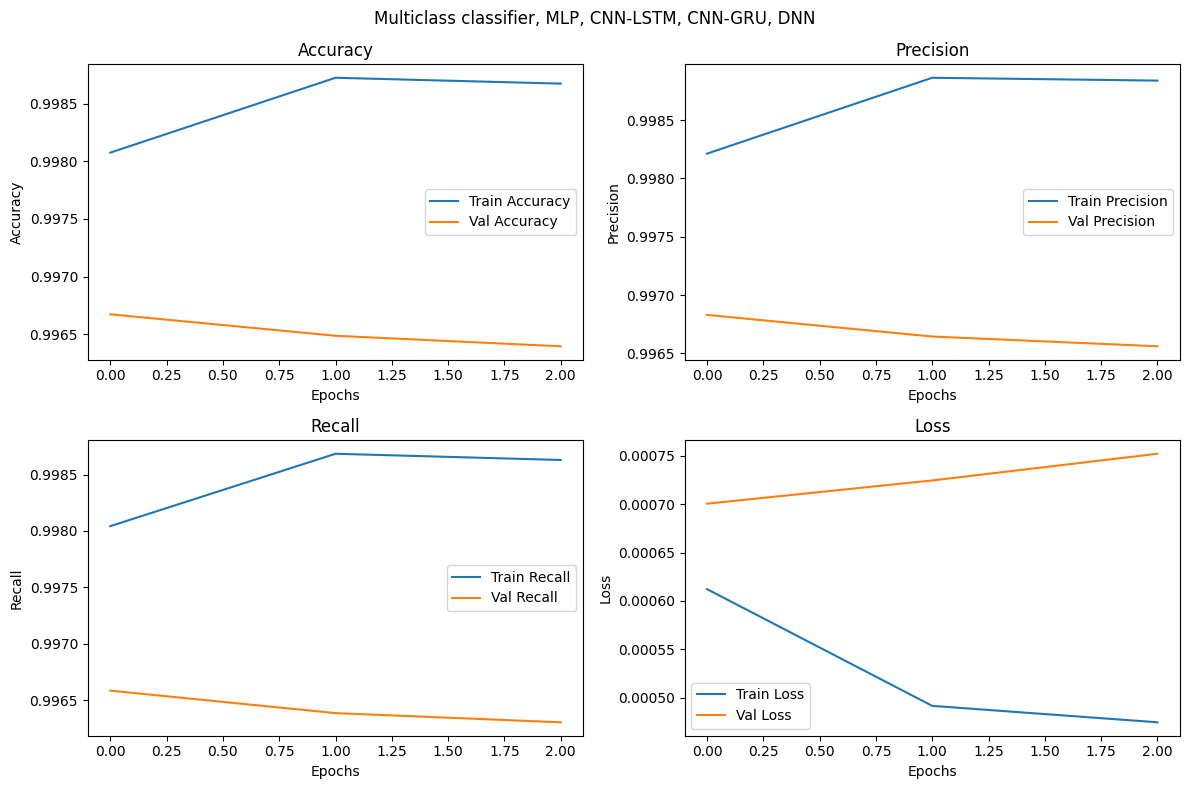

In [157]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files, seq_length=128, seq_shift=128)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_dnn_classifier1.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass classifier, MLP, CNN-LSTM, CNN-GRU, DNN')

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Accuracy: 99.858%
Precision: 99.612%
Recall: 99.620%
F1 : 0.99616
Kappa: 0.99363


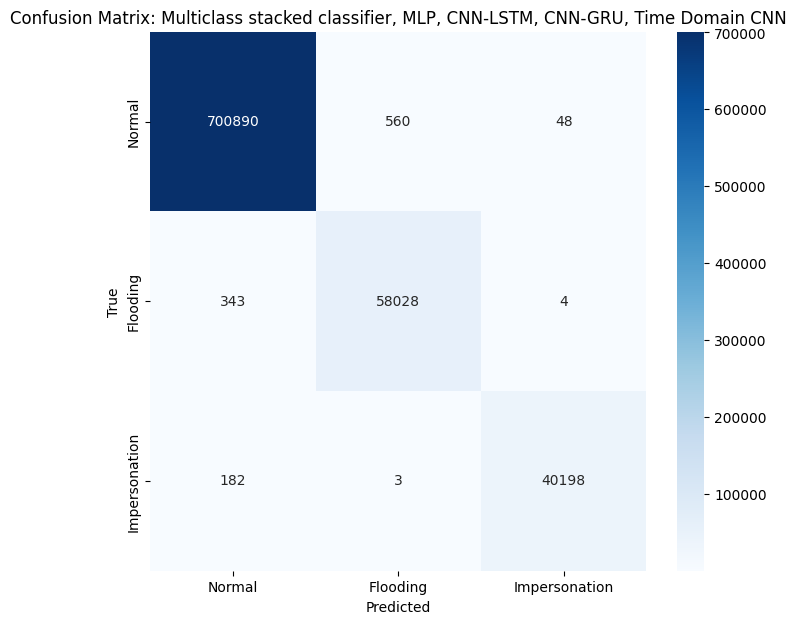

In [158]:
#multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_dnn_classifier1.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_dnn_classifier1_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, MLP, CNN-LSTM, CNN-GRU, Time Domain CNN", binary=False, average='macro')

### Top 3 Multiclass models

|                       | Accuracy | Precision | Recall  | F1      | Kappa   |
|-----------------------|----------|-----------|---------|---------|---------|
| CNN-LSTM              | 99.238%  | 96.198%   | 99.089% | 0.9754  | 0.9509  |
| CNN-GRU               | 99.032%  | 94.927%   | 99.077% | 0.9684  | 0.9384  |
| DNN                   | 98.873%  | 94.268%   | 99.370% | 0.9659  | 0.9292  |
| Arithmetic mean       | 99.078%  | 95.200%   | 99.497% | 0.9719  | 0.9414  |
| Improvement from best | -0.160%  | -0.902%   |  0.408% | -0.0030 | -0.0095 |
| F1 weighted mean      | 99.080%  | 95.244%   | 99.486% | 0.9720  | 0.9415  |
| Improvement from best | -0.158%  | -0.858%   |  0.397% | -0.0029 | -0.0094 |
| Kappa weighted mean   | 99.081%  | 95.260%   | 99.481% | 0.9721  | 0.9416  |
| Improvement from best | -0.157%  | -0.842%   |  0.392% | -0.0028 | -0.0093 |
| Softmax regression    | 99.073%  | 95.160%   | 99.481% | 0.9715  | 0.9411  |
| Improvement from best | -0.165%  | -0.942%   |  0.392% | -0.0034 | -0.0098 |
| MLP                   | 99.076%  | 95.189%   | 99.490% | 0.9718  | 0.9413  |
| Improvement from best | -0.162%  | -0.913%   |  0.401% | -0.0031 | -0.0096 |

In [72]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Average
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]
#combined_output = Concatenate(axis=-2)(base_classifiers_outputs)


y = Average()(base_classifiers_outputs)

mul_arithmetic_mean_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_arithmetic_mean_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_arithmetic_mean_aggregate2.summary()

Model: "functional_110"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      3,699 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, None, 3)   │      4,451 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, None, 3)   │      4,303 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_3 (Average) │ (None, None, 3)   │          0 │ sequential[0][0], │
│                     │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,453 (48.64 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,453 (48.64 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step
Accuracy: 99.057%
Precision: 96.183%
Recall: 99.526%
F1 : 0.97748
Kappa: 0.95918


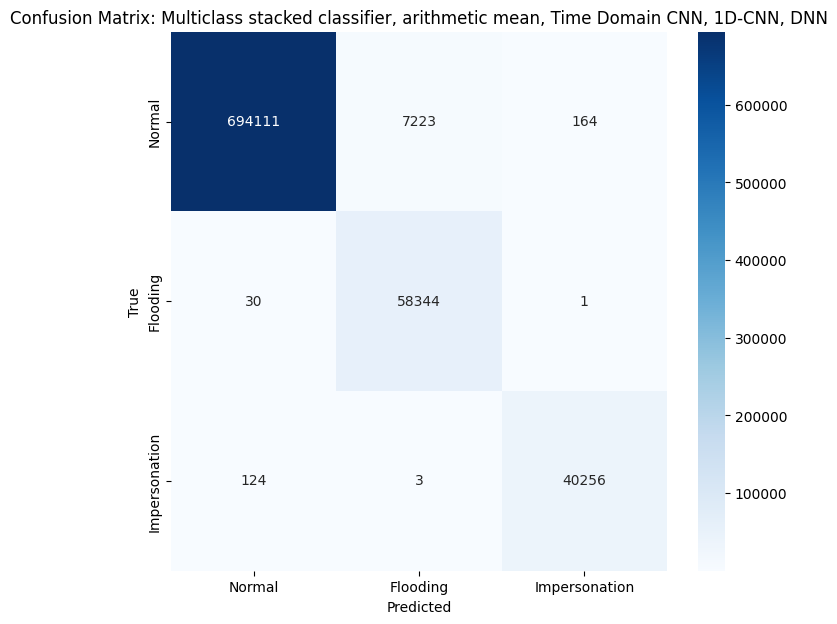

In [73]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_arithmetic_mean_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()

    
mul_arithmetic_mean_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, arithmetic mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [74]:
import math
from keras.layers import Input, Dense, TimeDistributed, Lambda

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_f1_weights = [
    mul_td_cnn_metrics[3],
    mul_dnn_metrics[3],
    mul_cnn1d_metrics[3],
]

mul_f1_weights = [math.log(w / (1 - w)) for w in mul_f1_weights]

sum_mul_f1_weights = sum(mul_f1_weights)

mul_f1_weights = tf.constant([w / sum_mul_f1_weights for w in mul_f1_weights], dtype=tf.float32, shape=(len(mul_f1_weights), 1))

print('F1 calculated_weights')
print(mul_f1_weights.numpy())

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_f1_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_f1_weighted_aggregate2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_f1_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_f1_weighted_aggregate2.summary()

F1 calculated_weights
[[0.32968187]
 [0.3395765 ]
 [0.33074158]]


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      3,699 │ input_layer_13[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, None, 3)   │      4,451 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_30 │ (None, None, 3)   │      4,303 │ input_layer_13[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, None, 3,   │          0 │ sequential[1][0], │
│                     │ 3)                │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, None, 3)   │          0 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_18 (Lambda)  │ (None, None, 3)   │          0 │ lambda_17[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,453 (48.64 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,453 (48.64 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step
Accuracy: 99.058%
Precision: 96.183%
Recall: 99.530%
F1 : 0.97749
Kappa: 0.95921


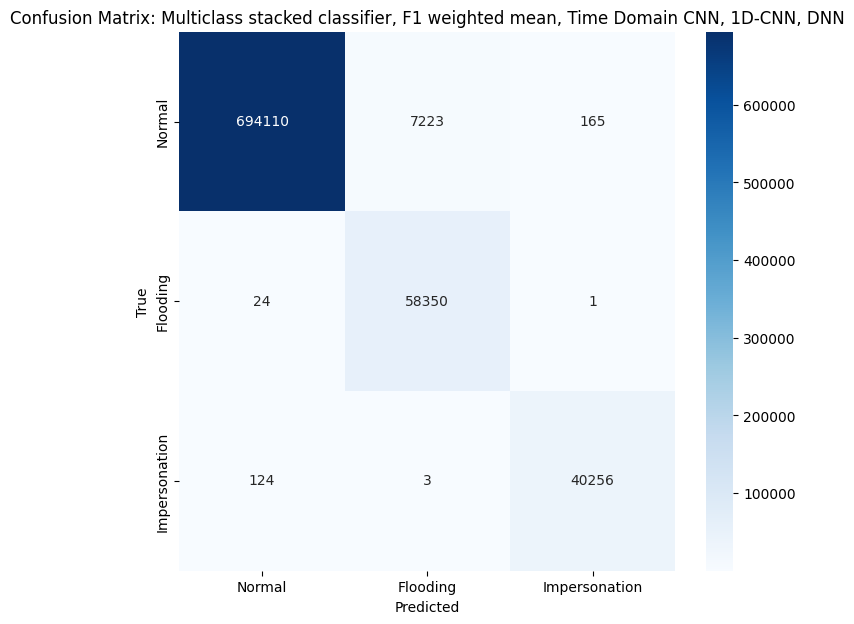

In [75]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_f1_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_f1_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, F1 weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [76]:
from keras.layers import Input, Dense, TimeDistributed, Lambda
import math

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

mul_kappa_weights = [
    mul_td_cnn_metrics[4],
    mul_dnn_metrics[4],
    mul_cnn1d_metrics[4],
]

mul_kappa_weights = [math.log(w / (1 - w)) for w in mul_kappa_weights]

sum_mul_kappa_weights = sum(mul_kappa_weights)

mul_kappa_weights = tf.constant([w / sum_mul_kappa_weights for w in mul_kappa_weights], dtype=tf.float32,  shape=(len(mul_kappa_weights), 1))

print('Cohe Kappa calculated_weights')
print(mul_kappa_weights.numpy())

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Lambda(lambda x: tf.stack(x, axis = -1))(base_classifiers_outputs)
y = Lambda(lambda x: tf.multiply(x, mul_kappa_weights), output_shape=(None, 3))(y)
y = Lambda(lambda x: tf.reduce_sum(x, axis =-1), output_shape=(None, 3))(y)

mul_kappa_weighted_aggregate2 = tf.keras.Model(input, y)

mul_kappa_weighted_aggregate2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_kappa_weighted_aggregate2.summary()

Cohe Kappa calculated_weights
[[0.33487755]
 [0.33727673]
 [0.3278457 ]]


Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      3,699 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_32 │ (None, None, 3)   │      4,451 │ input_layer_14[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_33 │ (None, None, 3)   │      4,303 │ input_layer_14[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, None, 3,   │          0 │ sequential[2][0], │
│                     │ 3)                │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, None, 3)   │          0 │ lambda_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, None, 3)   │          0 │ lambda_20[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,453 (48.64 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,453 (48.64 KB)

391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step
Accuracy: 99.058%
Precision: 96.189%
Recall: 99.529%
F1 : 0.97752
Kappa: 0.95924


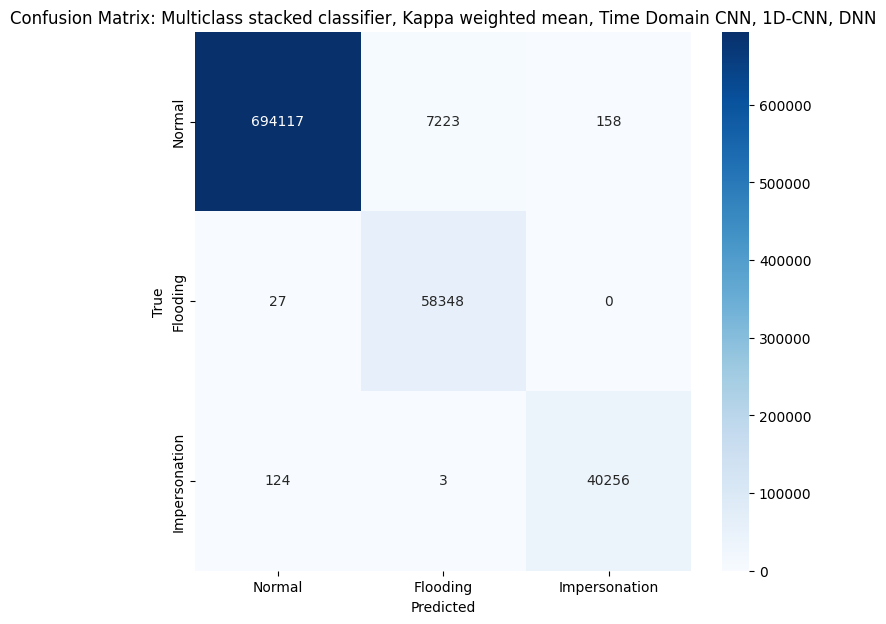

In [77]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
y_pred = mul_kappa_weighted_aggregate2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
    
mul_kappa_weighted_aggregate2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, Kappa weighted mean, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [78]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomNormal
input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_softmax_regression2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_softmax_regression2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_softmax_regression2.summary()

Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      3,699 │ input_layer_15[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_34 │ (None, None, 3)   │      4,451 │ input_layer_15[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_35 │ (None, None, 3)   │      4,303 │ input_layer_15[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, None, 9)   │          0 │ sequential[3][0], │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_36 │ (None, None, 3)   │         30 │ concatenate_14[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,483 (48.76 KB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 12,453 (48.64 KB)

Epoch 1/2
     59/Unknown 47s 591ms/step - accuracy: 0.9617 - loss: 0.0044 - precision: 0.9621 - recall: 0.9615

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


59/59 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.9620 - loss: 0.0043 - precision: 0.9623 - recall: 0.9617 - val_accuracy: 0.9937 - val_loss: 0.0010 - val_precision: 0.9942 - val_recall: 0.9932
Epoch 2/2
59/59 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9701 - loss: 0.0027 - precision: 0.9712 - recall: 0.9689 - val_accuracy: 0.9911 - val_loss: 0.0011 - val_precision: 0.9915 - val_recall: 0.9909


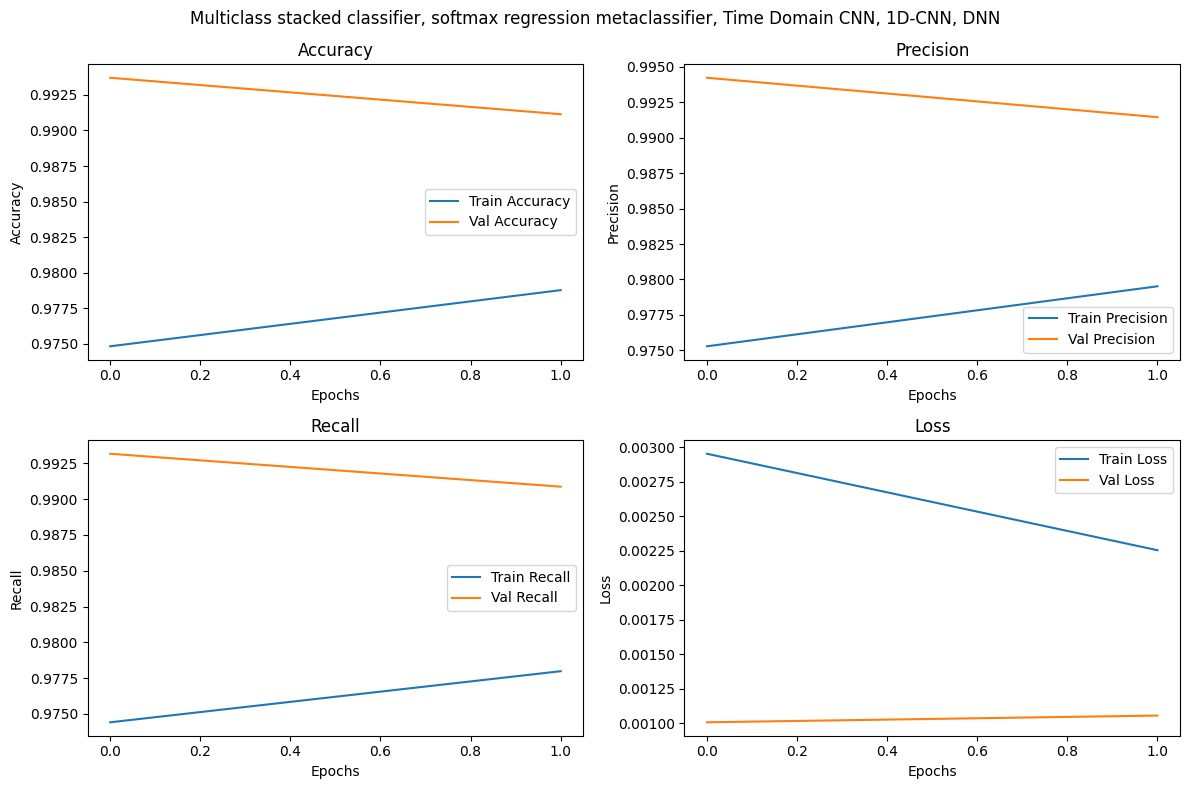

In [160]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files, seq_length=128, seq_shift=128)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)
metaclassifier_epochs = 2
history = mul_softmax_regression2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN')

In [161]:
output_layer = mul_softmax_regression2.layers[-1].layer.trainable_weights

output_weights = output_layer[0].numpy()
output_bias = output_layer[1].numpy()

print("Softmax regressor weights:\n", output_weights)
print("Softmax regressor bias: ", output_bias)

Softmax regressor weights:
 [[ 0.45160553 -0.9006897  -1.6721903 ]
 [-1.0557793   0.938088   -0.3070564 ]
 [-0.23366067 -0.86799616  0.4188234 ]
 [ 0.6041726  -1.54666    -0.66243213]
 [-0.7597655   1.1426545  -1.4144546 ]
 [-1.197659   -0.36572942  1.094471  ]
 [ 0.6025737  -0.03905595  0.21785766]
 [ 0.1749043  -0.12465387 -2.0909162 ]
 [-0.71569556 -0.5980573   0.19749992]]
Softmax regressor bias:  [ 0.41402766 -0.06529111 -0.5919362 ]


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Accuracy: 99.375%
Precision: 98.485%
Recall: 98.355%
F1 : 0.98420
Kappa: 0.97206


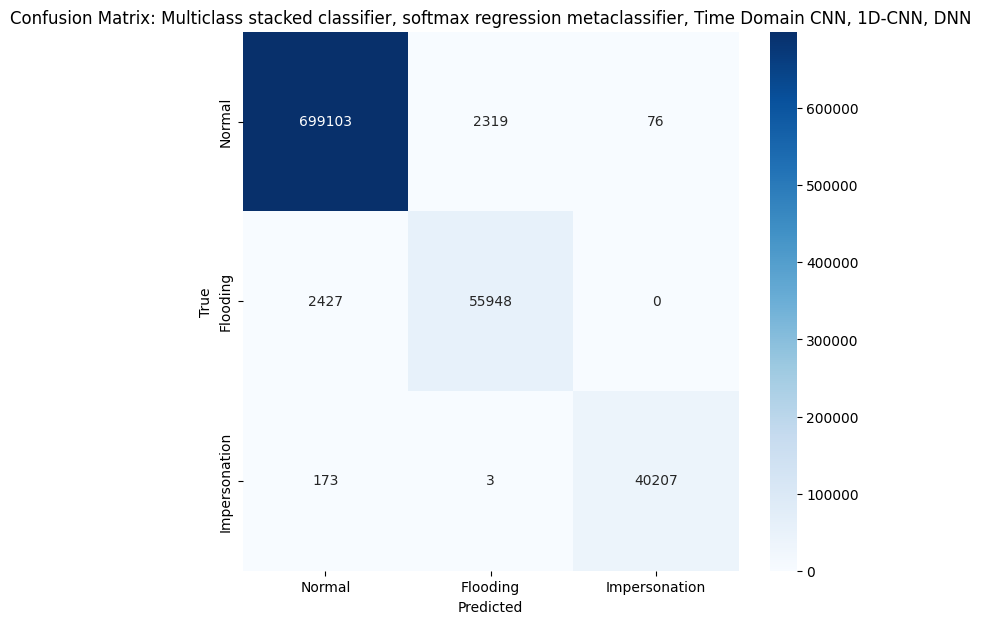

In [162]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
y_pred = mul_softmax_regression2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
    
mul_softmax_regression2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, softmax regression metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

In [82]:
from keras.layers import Input, Dense, TimeDistributed, Concatenate, Reshape, Dense
from tensorflow.keras.initializers import RandomNormal

input_shape = (None, n_features)
input = Input(input_shape)

td_mul_dnn_model = TimeDistributed(mul_dnn_model)
td_mul_cnn1d_model = TimeDistributed(mul_cnn1d_model)


mul_base_classifiers = [
    mul_td_cnn_model,
    td_mul_dnn_model,
    td_mul_cnn1d_model
]

# disabling training and dropout of base classifiers
for bc in mul_base_classifiers:
    if isinstance(bc, TimeDistributed):
        bc = bc.layer
    bc.trainable=False
    for layer in bc.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

base_classifiers_outputs = [bc(input) for bc in mul_base_classifiers]

y = Concatenate()(base_classifiers_outputs)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(4, activation='relu'))(y)
y = TimeDistributed(Dense(3, activation='softmax'))(y)

mul_dnn_classifier2 = tf.keras.Model(input, y)

metaclassifier_epochs = 4

mul_dnn_classifier2.compile(
    optimizer = 'adam',
    loss = 'categorical_focal_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

mul_dnn_classifier2.summary()

Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None, 39)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None, 3)   │      3,699 │ input_layer_16[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_37 │ (None, None, 3)   │      4,451 │ input_layer_16[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_38 │ (None, None, 3)   │      4,303 │ input_layer_16[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, None, 9)   │          0 │ sequential[4][0], │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_39 │ (None, None, 4)   │         40 │ concatenate_15[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_40 │ (None, None, 4)   │         20 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_41 │ (None, None, 3)   │         15 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,528 (48.94 KB)

 Trainable params: 75 (300.00 B)

 Non-trainable params: 12,453 (48.64 KB)

Epoch 1/2
    504/Unknown 495s 960ms/step - accuracy: 0.9940 - loss: 8.3236e-04 - precision: 0.9942 - recall: 0.9939

/home/filip/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


504/504 ━━━━━━━━━━━━━━━━━━━━ 594s 1s/step - accuracy: 0.9940 - loss: 8.3234e-04 - precision: 0.9942 - recall: 0.9939 - val_accuracy: 0.9860 - val_loss: 0.0021 - val_precision: 0.9862 - val_recall: 0.9859
Epoch 2/2
504/504 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.9951 - loss: 7.7422e-04 - precision: 0.9953 - recall: 0.9950 - val_accuracy: 0.9861 - val_loss: 0.0021 - val_precision: 0.9862 - val_recall: 0.9860


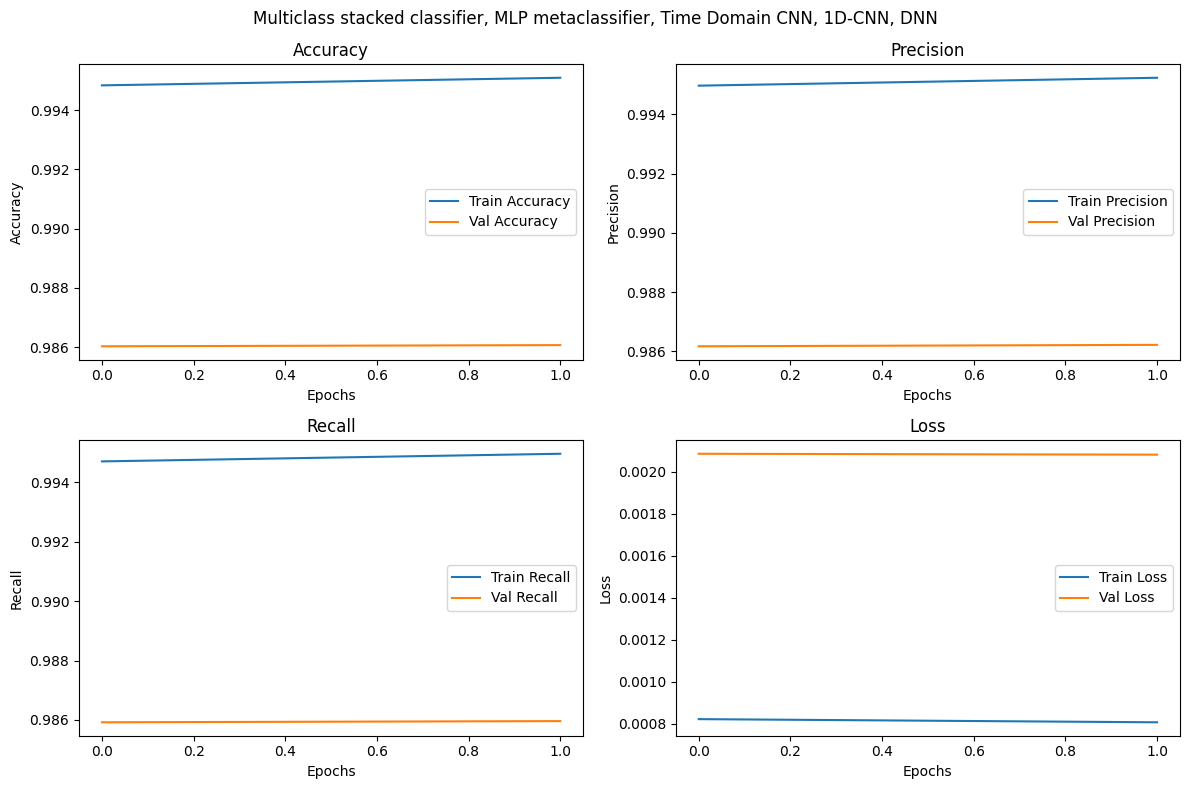

In [185]:
train_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(train_seq_files)
val_mul_seq_ds = data_utils.create_multiclass_sequential_dataset(val_seq_files)

history = mul_dnn_classifier2.fit(
    train_mul_seq_ds,
    validation_data = val_mul_seq_ds,
    epochs = metaclassifier_epochs
)

plot_model_history(history.history, 'Multiclass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN')

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Accuracy: 99.305%
Precision: 99.682%
Recall: 96.820%
F1 : 0.98178
Kappa: 0.96818


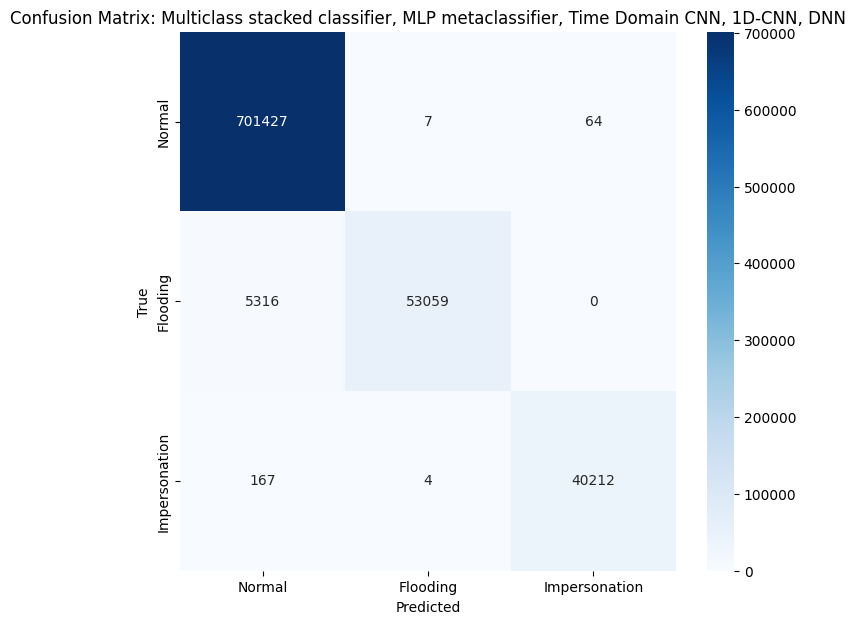

In [186]:
# multiclass_sequential_test_ds = data_utils.create_multiclass_sequential_dataset(test_seq_files)
# features = []
# labels = []

# for x, y in multiclass_sequential_test_ds:
#     features.append(x)
#     labels.append(y)

# features = tf.concat(features, axis=0)
# labels = tf.concat(labels, axis=0)
# y_true = tf.argmax(labels, axis=2).numpy().flatten()
y_pred = mul_dnn_classifier2.predict(features)
y_pred = tf.argmax(y_pred, axis=2).numpy().flatten()
    
mul_dnn_classifier2_metrics = score_and_confusion_matrix(y_pred, y_true, "Multiclass stacked classifier, MLP metaclassifier, Time Domain CNN, 1D-CNN, DNN", binary=False, average='macro')

|                       | Accuracy | Precision | Recall  | F1      | Kappa   |
|-----------------------|----------|-----------|---------|---------|---------|
| Time Domain CNN       | 96.971%  | 78.809%   | 69.121% | 0.7053  | 0.7790  |
| 1D-CNN                | 98.807%  | 93.063%   | 99.281% | 0.9593  | 0.9253  |
| DNN                   | 98.873%  | 94.268%   | 99.370% | 0.9659  | 0.9292  |
| Arithmetic mean       | 98.911%  | 94.568%   | 99.221% | 0.9667  | 0.9314  |
| Improvement from best |  0.038%  |  0.300%   | -0.149% | 0.0008  | 0.0022  |
| F1 weighted mean      | 98.565%  | 90.508%   | 99.200% | 0.9450  | 0.9114  |
| Improvement from best | -0.308%  | -4.360%   | -0.170% | -0.0209 | -0.0176 |
| Kappa weighted mean   | 98.818%  | 93.667%   | 99.203% | 0.9619  | 0.9259  |
| Improvement from best | -0.093%  | -0.601%   | -0.167% | -0.0040 | -0.0033 |
| Softmax regression    | 98.849%  | 93.633%   | 99.299% | 0.9624  | 0.9278  |
| Improvement from best | -0.044%  | -0.635%   | -0.167% | -0.0035 | -0.0024 |
| MLP                   | 98.948%  | 93.479%   | 99.422% | 0.9627  | 0.9336  |
| Improvement from best |  0.075%  | -0.789%   |  0.072% | -0.0032 | 0.0044  |